In [1]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import os
import math

from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import scipy.stats as stats

import csv

#from mpltools import special ##leon

# for 3d plot
#import numpy as np
#import matplotlib.pyplot as plt
from matplotlib import cm
#from mpl_toolkits.mplot3d import Axes3D

#plt.style.use('seaborn-poster')
#plt.style.use('fivethirtyeight')
#plt.style.use('grayscale')
#plt.style.use('seaborn-colorblind')


# DEFINE DATA CLASS
class RawData(object):
    def __init__(self,timestamp,keytime,ttime,keypress,targetid,target_lon,target_lat,target_x,target_y,target_z,hmd_rx,hmd_ry,hmd_rz):
        self.timestamp=timestamp # 1 (default time?)
        self.keytime=keytime # 2 +Time.deltaTime
        self.ttime=ttime # 3 Time.time
        self.keypress=keypress # 4
        self.targetid=targetid # 5
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.target_x=target_x
        self.target_y=target_y
        self.target_z=target_z
        self.hmd_rx=hmd_rx # 11
        self.hmd_ry=hmd_ry # 12
        self.hmd_rz=hmd_rz # 13

class TimeData(object):
    def __init__(self,targetid,target_lon,target_lat,deltatime):
        self.targetid=targetid
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.deltatime=deltatime


LAT_KEY = ('-30','0','30')
LON_KEY = ('0','30','60','90','120','150','180')
LAT_KEY_F = (-30,0,30)
LON_KEY_F = (0,30,60,90,120,150,180)
    
    
class User(object):
    def __init__(self, lat, lon, user, test):
        self.lat=lat
        self.lon=lon
        self.user=user
        self.test=test
        self.speed_array = [[] for x in range(5)]
        self.time_array = [[] for x in range(5)]
        self.speed_raw = [[] for x in range(5)]
        self.time_raw = [[] for x in range(5)]
        self.speed_mean = [[] for x in range(5)]
        self.speed_std = [[] for x in range(5)]
        self.time_mean = [[] for x in range(5)]
        self.time_std = [[] for x in range(5)]
        
        self.time_median = [[] for x in range(5)]
        self.speed_median = [[] for x in range(5)]
        #print(np.array(self.speed_array).shape)
        
        self.round_array = []
        self.round_data = [[] for x in range(5)]
        
        self.time_5x3x7x4=self.time_array
        self.time_5x3x7_mean=self.time_mean
        self.time_5x3x7_median=self.time_median
        self.time_5x4=self.round_data
        
        
        


        
    ## READ DATA
    def _read_data(self, file):
        raw_data=[]
        print("Reading %s"%file)
        seperator="\t"
        with open(file,"r") as fp:
            for line in fp:
                if line.startswith("Time"):
                    continue     ## Skip the Header
                l=line[:-1]   ## Delete the Last Element then Return
                f=l.split(seperator)   ## Divide the Raw Data to Pieces
                if(int(f[3])==1):   ## 4.When Finish Targeting and Press Key
                    raw_data.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),float(f[5]),float(f[6]),float(f[7]),float(f[8]),float(f[9]),float(f[10]),float(f[11]),float(f[12])))
                else: 
                    raw_data.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),0,0,0,0,0,float(f[10]),float(f[11]),float(f[12])))

        return raw_data



    # Input Raw Data, Each Tester, return aim_time[[[,,,],,,,,][,,,,,][,,,,,]] 3-layer array
    # Every Target Aiming Time in aim_time[lat][lon] = [first, second, third]
    def _aim_time_filter(self, input_raw_data):
        aim_time={}
        filtered_data=[a for a in input_raw_data if a.keypress==1]

        for i in range(len(filtered_data)-1):
            if(filtered_data[i+1].targetid!=filtered_data[i].targetid):
                continue # when resuming back
            if((i <= (len(filtered_data)-3)) and
               (filtered_data[i-1].targetid==filtered_data[i+2].targetid) and
               (filtered_data[i-1].targetid==filtered_data[i].targetid) and
               (filtered_data[i-1].targetid==filtered_data[i+1].targetid)):
                continue # when two same targets appear one after one
            delta_time=filtered_data[i+1].ttime-filtered_data[i].ttime
            #print(delta_time, filtered_data[i].targetid)

            key1=str(int(filtered_data[i].target_lat))
            key2=str(int(filtered_data[i].target_lon))
            if(key1 in aim_time)==False:
                aim_time[key1]={}
            if(key2 in aim_time[key1])==False:
                aim_time[key1][key2]=[]

            aim_time[key1][key2].append(TimeData(filtered_data[i].targetid,filtered_data[i].target_lon,filtered_data[i].target_lat,delta_time))

        aim_time[str(0)][str(0)]=[]   # Special (0,0) Not Exist but for data processing, add a pseudo datum
        aim_time[str(0)][str(0)].append(TimeData(float(21),float(0),float(0),float(0)))

        return aim_time   # aim_time is 4*3*7 array{}

    LAT_KEY = ('-30','0','30')
    LON_KEY = ('0','30','60','90','120','150','180')

    def _extract_time(self, input_time):
        #lat = [a for a in input_time]
        #lon = [b for b in input_time[lat]]
        #target = [c.deltatime for c in input_time[lon] ]
        
        time_dict = {}
        time_flat = [] # not useful, not sorted
        
        
        print("!!TEST")
        print(self.test)
        
        if (self.test<3):
            lat_order = ['-30','0','30']
        else:
            lat_order = ['0']
        #lat_order = ['-30','0','30']
        lon_order = ['0','30','60','90','120','150','180']
        
        for lat in lat_order:
            time_dict[lat] ={}
            time_lon = []
            for lon in lon_order:
                time_dict[lat][lon] = [target.deltatime for target in input_time[lat][lon]]
                time_target = [target.deltatime for target in input_time[lat][lon]]
                time_lon.append(time_target)
            time_flat.append(time_lon)

        return time_dict, time_flat
    
    def _cal_round(self, input_time_dict, test):
        r=[[],[],[],[]]
        #print(input_time_dict)
        for lat in input_time_dict:
            for lon in input_time_dict[lat]:
                if ((lon=='0') and (lat=='0')):
                    continue
                for i in range(4):
                    #print("lat", lat, "lon", lon, "i", i, "value", input_time_dict[lat][lon][i])
                    if (i >= len(input_time_dict[lat][lon])):
                        print("Round "+str(i+1)+"("+lat+","+lon+" Not Enough Data")
                        #r[i].append(input_time_dict[lat][lon][-1])
                        r[i].append(np.mean(input_time_dict[lat][lon]))
                    else:
                        r[i].append(input_time_dict[lat][lon][i])
                    

                
        self.round_array = [np.sum(r[0]), np.sum(r[1]), np.sum(r[2]), np.sum(r[3])]
        
        #print(round_array)
        if (False):
            fig,ax=plt.subplots()
            width = 0.6
            plt.bar(range(4), self.round_array, width, label='Round Time', color="G")
            plt.title('Test '+ str(test))
            ax = plt.gca()
            ax.yaxis.grid(True, linestyle = "--")      
            plt.show()
        
        return self.round_array

    def _flatten_data(self, input_data):
        
        flat_data = []
        
        for lat in input_data:
            data_lon = []
            for lon in input_data[lat]:
                data_target = [target for target in input_data[lat][lon]]
                data_lon.append(data_target)
            flat_data.append(data_lon)
        
        return flat_data
    
    def _time_to_speed(self, input_time):
        
        speed={}
        
        for lat in input_time:
            speed[lat]={}
            for lon in input_time[lat]:
                speed[lat][lon]=[]
                for target in range(len(input_time[lat][lon])):
                    if (input_time[lat][lon][target]==0):
                        #r.append(0) # speed = 0
                        speed[lat][lon].append(0)
                        continue
                    
                    angle = User._angle_ac(self, int(lat), int(lon))
                    speed[lat][lon].append( angle / input_time[lat][lon][target] )

        return speed    # 3*3*7 array{}

    def _angle_ap(self, lat, lon):
        angle = math.sqrt( lat**2 + lon**2 )
        return angle

    def _angle_ac(self, lat, lon):
        angle = math.degrees( math.acos( math.cos(math.radians(lat)) * math.cos(math.radians(lon)) ) )
        return angle

    # Calculate the Mean and STD
    def _dict_stat(input_dict): # return

        key1=['-30','0','30']    # 3 lat
        if (len(input_dict) == 1):
            key1=['0']    # 1 lat
        key2=[0,30,60,90,120,150,180]
        
        #key3= [lat for lat in input_dict]
        #key4= [lon for lon in input_dict[key3[0]]]
        key3 = input_dict.keys()
        key4 = input_dict['0'].keys()
    
        if (tuple(input_dict.keys()) != User.LAT_KEY):
            print('Error may happen')
        
        target_mean={}
        target_std={}
        for lat in input_dict:
            target_mean[lat]={}
            target_std[lat]={}
            for lon in input_dict[lat]:
                if(input_dict[lat][lon]==[0]):
                #if(k2==0):
                    target_mean[lat][lon]=0
                    target_std[lat][lon]=0
                    continue
                
                target_mean[lat][lon]=np.mean(input_dict[lat][lon])
                target_std[lat][lon]=np.std(input_dict[lat][lon])

        return target_mean, target_std    # 3*7 array[]

    def _list_stat(input_data): # return
        
        #print(np.array(input_data).shape)
            
        target_mean=[]
        target_std=[]
        target_median=[]
        
        #for lon in range(len(input_data)):
        for lat in range(len(input_data)):
            mean=[]
            std=[]
            median=[]
            #for lat in range(len(input_data[lon])):
            for lon in range(7):
                #if(lon==1 and lat==0):
                #if(k2==0):
                if (input_data[lat][lon] == [0]):
                    mean.append(0)
                    std.append(0)
                    median.append(0)
                    continue
                data = [target for target in input_data[lat][lon]]
                mean.append(np.mean(data))
                std.append(np.std(data))
                median.append(np.median(data))
                        
    
            target_mean.append(mean)
            target_std.append(std)
            target_median.append(median)

        return target_mean, target_std, target_median    # 3*7 array[]


    def add_test(self, test, file):
        
        print("test", self.test)
        self.test = test
        print("test", self.test)
        
        
        raw_data = User._read_data(self, file)
        aim_time = User._aim_time_filter(self, raw_data)
        time_dict, time_flat1 = User._extract_time(self, aim_time)
        
        self.round_data[test-1] = User._cal_round(self, time_dict, test)##
        
        time_flat = User._flatten_data(self, time_dict)
        speed_dict = User._time_to_speed(self, time_dict)
        speed_flat = User._flatten_data(self, speed_dict)
        
        #print(np.array(time_flat1)==np.array(time_flat))
        
        #self.speed_array.append(np.array(speed_flat))
        self.time_array[test-1] = time_flat
        self.speed_array[test-1] = speed_flat
        #self.time_raw.append(time_dict)
        self.time_raw[test-1] = time_dict
        self.speed_raw[test-1] = speed_dict
        
        #### mean or median here
        
        self.time_mean[test-1], self.time_std[test-1], self.time_median[test-1] = User._list_stat(time_flat)
        self.speed_mean[test-1], self.speed_std[test-1], self.speed_median[test-1] = User._list_stat(speed_flat)
        
        #self.time_mean = User._dict_stat
    
    def dict_print(dict_to_print):
        for x in dict_to_print:
            print ('--', x, '--')
            for y in dict_to_print[x]:
                print (y,':', dict_to_print[x][y])
                
    #def _mean(self, array):
    
    def cal_ratio(before, after):
        
        ratio=[]
        log=[]
        
        for i in range(len(before)):
            r=[]
            l=[]
            #print(len(before[i]))
            for j in range(len(before[i])):
                if(after[i][j]==0):
                    r.append(1) #ratio
                    l.append(0) #log
                    continue
                r.append( after[i][j] / before[i][j] ) #ratio
                l.append( math.log2( after[i][j] / before[i][j] ) ) #log
                #print(i,j,mean_after[i][j],mean_before[i][j])
            ratio.append(r)
            log.append(l)
            
        #print(np.array(ratio).shape)
        #print(np.array(log).shape)
        return ratio, log
    
    def ratio_of(self, data_type, average_type, before, after):
        if (data_type == 'time'):
            if (average_type == 'mean'):
                data_before = self.time_mean[before-1]
                data_after = self.time_mean[after-1]
            if (average_type == 'median'):
                data_before = self.time_median[before-1]
                data_after = self.time_median[after-1]
                
        if (data_type == 'speed'):
            if (average_type == 'mean'):
                data_before = self.speed_mean[before-1]
                data_after = self.speed_mean[after-1]
            if (average_type == 'median'):
                data_before = self.speed_median[before-1]
                data_after = self.speed_median[after-1]
            
        
        #print(np.array(self.speed_mean).shape)
        
        #print(np.array(self.speed_mean[before-1]).shape, np.array(data_before).shape)
        ratio0, log0 = User.cal_ratio(data_before, data_after)
        return ratio0, log0
            
        
        

    


class Exp(object):
    def __init__(self, _test_order, _user_order, _lat, _lon):
        self._test_order=_test_order
        self.lat=_lat
        self.lon=_lon
        self.user_order = _user_order
        
        self.time_mean_10x3x7 = [] #10*3*7
        self.time_mean_3x7x10 = [] #3*7*10
        self.time_mean_3x7 = [] #3*7
        self.time_std_3x7 = []
        self.time_mean_lon = [] #7
        self.time_mean_lat = [] #3
        self.time_mean_overall = 0 #1
        
        self.time_median_10x3x7 = [] #10*3*7
        
        self.speed_mean_10x3x7 = [] #10*3*7
        self.speed_mean_3x7x10 = [] #3*7*10
        self.speed_mean_3x7 = [] #3*7
        self.speed_std_3x7 = []
        self.speed_mean_lon = [] #7
        self.speed_mean_lat = [] #3
        self.speed_mean_overall = 0 #1
        
        self.speed_median_10x3x7 = [] #10*3*7
        
        self.no_user=True
        
        self.round_10x4 = []
        self.condition_10 = []
        
        
        
        self.time_10x3x7x4 = []
        #self.time_4x10 = self.round_10x4 #round time, sum
        #self.time_10x3x7_mean = self.time_mean_10x3x7
        #self.time_3x7x10_mean=[] #target time
        #self.time_20x10_mean #target time
        #self.time_10x3x7_median = self.time_median_10x3x7
        #self.time_3x10 = [] #lat time, sum
        #self.time_7x10 = [] #lon time, sum
        #self.time_10 = [] #condition time, sum
        
        self.median=[]
        
        
    class Average(object):
        def __init__(self, input_time_10x3x7x4, a_type):
            self.time_10x3x7x4 = input_time_10x3x7x4
            self.time_10x3x7 =[]
            self.time_3x7x10=[]
            self.time_3x10=[]
            self.time_7x10=[]
            self.time_20x10=[]
            self.average_type=a_type
            
            if (self.average_type == 'median'):
                self._average = np.median
            elif (self.average_type == 'mean'):
                self._average = np.mean
            else:
                self._average = np.mean
        
            
        def _cal_10x3x7(self, input_data):
            user=[]
            for userx in range(len(input_data)):
                lat=[]
                for latx in range(len(input_data[0])):
                    lon=[]  
                    #for lat in range(len(input_data[lon])):
                    for lonx in range(len(input_data[0][0])):
                        if (np.array(input_data).shape == (1,3,7)):
                            lon.append(input_data[userx][latx][lonx])
                            continue
                        if (input_data[userx][latx][lonx] == [0.0]):
                            lon.append(0)
                            continue
                        data = input_data[userx][latx][lonx]
                        #print(data)
                        lon.append(self._average(data))
                    lat.append(lon)
                user.append(lat)
            
            #print('###10x3x7###')  
            self.time_10x3x7 = user
            #print(np.array(self.time_10x3x7).shape)
            #print('###7x3x10###')  
            self.time_7x3x10 = np.array(user).T

            
            user_lat=[]
            for userx in range(len(input_data)): # 10x3x7
                user_lat.append([np.sum(i) for i in user[userx]])
                
            #user_lat.append([np.sum(i) for i in userx]) for userx in user
            
            #print(np.array(user[0]).shape)
            #print(np.array(user[0]).T.shape)
            user_lon=[]
            for userx in range(len(input_data)):
                user_lon.append([np.sum(i) for i in np.array(user[userx]).T])
                
            user_target=[]
            for userx in range(len(input_data)):
                user_target.append([i for i in np.array(user[userx]).flatten() if (i!=0)])
            
            user_round=[[np.sum(user[userx])] for userx in range(len(input_data))]
            
            if (np.array(input_data[0][0][0]).shape != ()):
                user_round_4=[]
                for userx in input_data: #10
                    user_r=np.zeros(4)
                    for lat in userx: #3
                        for lon in lat: #7
                                target_temp=lon[:]
                                #target_temp=lon #NO! LINKED
                                if (len(target_temp) <4):
                                    for i in range(4-len(target_temp)):
                                        target_temp.append(np.mean(lon)) 

                                if (len(target_temp) >4):
                                    target_temp=target_temp[:4]

                                user_r = user_r + np.array(target_temp)

                    user_round_4.append(list(user_r))
                
                self.time_10x4=user_round_4
                self.time_4x10=np.array(user_round_4).T
                self.time_4_mean=[np.mean(i) for i in np.array(user_round_4).T]
            

            #return user
            #print('###3x10###')  
            self.time_3x10=np.array(user_lat).T
            self.time_3_mean=[np.mean(i) for i in np.array(user_lat).T]
            #print(self.time_3x10.shape)
            #print('###7x10###')  
            self.time_7x10=np.array(user_lon).T
            self.time_7_mean = [np.mean(i) for i in np.array(user_lon).T]
            #print(self.time_7x10.shape)
            #print('###20x10###')  
            self.time_20x10=np.array(user_target).T
            self.time_20_mean = [np.mean(i) for i in np.array(user_target).T]
            #print(self.time_20x10.shape)
            
            
            self.time_7x3_mean = [[np.mean(j) for j in i] for i in np.array(user).T]
            self.time_7x3_std = [[np.std(j) for j in i] for i in np.array(user).T]
            self.time_3x7_mean = np.array(self.time_7x3_mean).T
            self.time_3x7_std = np.array(self.time_7x3_std).T
            self.time_1x10 = np.array(user_round).T
            self.time_1_mean = np.mean(np.array(user_round).T)
        
        
        def _cal_3x7x10(self, input_data):
            lat=[]    
            for latx in range(len(input_data[0])):
                lon=[]
                #for lat in range(len(input_data[lon])):
                for lonx in range(len(input_data[0][0])):
                    target=[]
                    for userx in range(len(input_data)):
                        if (np.array(input_data).shape == (1,3,7)):
                            target.append(input_data[userx][latx][lonx])
                            continue
                        if (input_data[userx][latx][lonx] == [0]):
                            target.append(0)
                            continue
                        data = input_data[userx][latx][lonx]
                        target.append(self._average(data))
                    lon.append(target)
                lat.append(lon)
            #print(lat)
            
            user=lat[:] 
            if (False):
                userT= list(np.array(lat[:]).T)
                print(np.array(user).shape)
                print(np.array(userT).shape)
                lat_3=np.array([np.zeros(len(user[0][0])) for i in range(len(user))])
                for lonx in range(len(user[0])):
                    temp=[ user[latx][lonx] for latx in range(len(user)) ]
                    lat_3 = lat_3 + np.array(temp)


                lon_7=np.array([np.zeros(len(userT[0][0])) for i in range(len(userT))])
                for lonx in range(len(userT[0])):
                    temp=[ userT[latx][lonx] for latx in range(len(userT)) ]
                    lon_7 = lon_7 + np.array(temp)

                tar_21=np.zeros(21)
                for tarx in range(21):
                    tar_21 = tar_21 + np.array(np.array(user).flatten()[tarx])
                tar_20 = np.delete(tar_21,7)

                #return lat, lat_3, lon_7, tar_20
                
                self.time_3x10=lat_3
                self.time_7x10=lon_7
                self.time_20x10=tar_20
                
            self.time_3x7x10=user
            
        

    def add_user(self, temp_user):
        #print('temp_user.time_array',temp_user.time_array[self._test_order-1])
        #print('self.data_group',np.array(self.data_group))
        self.time_mean_10x3x7.append(temp_user.time_mean[self._test_order-1])
        self.time_median_10x3x7.append(temp_user.time_median[self._test_order-1])
        
        self.speed_mean_10x3x7.append(temp_user.speed_mean[self._test_order-1]) #not accurate
        self.speed_median_10x3x7.append(temp_user.speed_median[self._test_order-1]) #not accurate
        
        self.round_10x4.append(temp_user.round_data[self._test_order-1])
        self.condition_10.append(np.sum(temp_user.round_data[self._test_order-1]))
        
        self.time_10x3x7x4.append(temp_user.time_5x3x7x4[self._test_order-1])
        
        #self.median = Median(temp_user.time_5x3x7x4[self._test_order-1])
    
        
        
    
    def _deform(input_data):
        result=[]
        for lat in range(len(input_data[0])):
            r=[]
            for lon in range(len(input_data[0][0])):
                all_user=[]
                for user in range(len(input_data)):
                    all_user.append(input_data[user][lat][lon])
                r.append(all_user)
            result.append(r)
        
        return result
    
    
    def _cal_mean_3x7(input_data):
        mean=[]
        std=[]
        #print(np.array(input_data))
        for lat in range(len(input_data[0])):
            m=[]
            s=[]
            for lon in range(len(input_data[0][0])):
                all_user=[]
                for user in range(len(input_data)):
                    all_user.append(input_data[user][lat][lon])
                m.append(np.mean(all_user)) # *7
                s.append(np.std(all_user))
            mean.append(m)
            std.append(s)# *3
            
        return mean, std
    
    
    def _cal_mean_1(input_data):
        #print(np.array(input_data))
        
        data = [i for i in np.array(input_data).flatten() if (i!=0)]
        #print(np.array(input_data).flatten())
        #mean = np.mean(np.delete(np.array(input_data), 7))
        #std = np.std(np.delete(np.array(input_data), 7))
        mean = np.mean(data)
        std = np.std(data)
            
        return mean
    
    
    def cal_mean_3_old(input_data): # input 3*7
        mean = [np.mean(input_data[i]) for i in range(len(input_data))]
        mean[1] = np.mean(input_data[1][1:]) # lat=0
        
        std = [np.std(input_data[i]) for i in range(len(input_data))]
        std[1] = np.std(input_data[1][1:]) # lat=0
        
        return mean, std
    
    def cal_mean_3(input_data): # input 10*3*7
        mean=[]
        std=[]
        for lat in range(3):
            data=[]
            
            for user in range(len(input_data)):  
                for lon in range(7):
                    if (input_data[user][lat][lon] == 0):
                        continue
                    data.append(input_data[user][lat][lon])
                    
            mean.append(np.mean(data)) 
            std.append(np.std(data))
        
        return mean, std
    
    
    def cal_mean_7_old(input_data_raw): # input 3*7
        input_data = np.array(input_data_raw).T
        mean = [np.mean(input_data[i]) for i in range(len(input_data))]
        mean[0] = np.mean([input_data[0][0],input_data[0][2]]) # lon=0
        
        std = [np.std(input_data[i]) for i in range(len(input_data))]
        std[1] = np.std([input_data[0][0],input_data[0][2]])# lat=0
        
        return mean, std
    
    def cal_mean_7(input_data): # input 10*3*7
        mean=[]
        std=[]
        #for lat in range(3):
        for lon in range(7):
            data=[]
            
            for user in range(len(input_data)):  
                #for lon in range(7):
                for lat in range(3):
                    if (input_data[user][lat][lon] == 0):
                        continue
                    data.append(input_data[user][lat][lon])
                    
            mean.append(np.mean(data)) 
            std.append(np.std(data))
        
        return mean, std
        
    
    def cal_mean(self):
        self.time_mean_3x7, self.time_std_3x7 = Exp._cal_mean_3x7(self.time_median_10x3x7)  #####median/mean
        self.time_mean_overall = Exp._cal_mean_1(self.time_median_10x3x7)                  #####median/mean
        
        self.speed_mean_3x7, self.speed_std_3x7 = Exp._cal_mean_3x7(self.speed_median_10x3x7) #####median/mean
        self.speed_mean_overall = Exp._cal_mean_1(self.speed_median_10x3x7)
        
       
        self.median=Exp.Average(self.time_10x3x7x4, 'median')
        self.median._cal_10x3x7(self.time_10x3x7x4)
        self.median._cal_3x7x10(self.time_10x3x7x4)
        
        self.mean=Exp.Average(self.time_10x3x7x4, 'mean')
        self.mean._cal_10x3x7(self.time_10x3x7x4)
        self.mean._cal_3x7x10(self.time_10x3x7x4)

        #self.time_mean_overall = np.mean(np.delete(np.array(self.time_mean_3x7), 7))
        #std
        #self.speed_mean_overall = np.mean(np.delete(np.array(self.speed_mean_3x7), 7))
        
        #self.time_mean_lat = [np.mean(self.time_mean_3x7[i]) for i in range(len(self.time_mean_3x7))]
        #self.time_mean_lat[1] = np.mean(self.time_mean_3x7[1][1:]) # lat=0
        #temp = np.transpose(self.time_mean_3x7)
        #self.time_mean_lon = [np.mean(temp[i]) for i in range(len(temp))]
        #self.time_mean_lon[0] = np.mean([temp[0][0],temp[0][2]]) # lon=0
        

def angle_ac(lat, lon):
    angle = math.degrees( math.acos( math.cos(math.radians(lat)) * math.cos(math.radians(lon)) ) )
    return angle

def displace():
    distance=[]
    for lat in [-30, 0, 30]:
        dis=[]
        for lon in [0, 30, 60, 90, 120, 150, 180]:
            angle = angle_ac(lat, lon)
            dis.append(angle)
        distance.append(dis)
    return distance   # 3*7 array{}

class Speed(object):
    def __init__(self, input_time, ttype=None):
        self.angle_3x7=displace()
        
        #print(np.array([self.angle_3x7]).shape)
        if (ttype is None):
            angle_data= [displace()]
        elif (ttype == '345'):
            angle_data= [[LON_KEY_F[:]] * 3]
        elif (ttype == '030'):
            angle_data= [[LON_KEY_F[:]]]
        else:
            print('Unknown Shape')
        angle=Exp.Average(angle_data, 'mean')
        angle._cal_10x3x7(angle_data)
        angle._cal_3x7x10(angle_data)
        
    
        self.angle=angle
        shape = np.array(input_time).shape
        u12 = 14
        u345 = 6
        #print(list(input_time[0]))
        print(shape)
        print(len(shape))
        #(input_time)
        if (len(shape)==3): 
            nozeros=[[[i if i!=0 else 1 for i in list(lon)] 
                  for lon in list(lat)] for lat in list(input_time)]
            
            if (shape[0]==3 and shape[1]==7): #3x7x10
                self.value = np.array(angle.time_3x7x10) / nozeros
            elif (shape[1]==7 and shape[2]==3):
                self.value = np.array(angle.time_3x7x10).T / nozeros
            elif (shape[1]==3 and shape[2]==7): #10x3x7
                self.value = np.array(angle.time_10x3x7) / nozeros
            else:
                print('Unknow Shape 3')
            
           
        elif (len(shape)==2): #3x7
            nozeros=[[i if i!=0 else 1 for i in list(lon)] 
                  for lon in list(input_time)]
            

            if (shape==(3,7)):
                self.value = np.array(angle.time_3x7_mean) / nozeros
            elif (shape==(7,3)):
                self.value = np.array(angle.time_7x3_mean) / nozeros
            elif (shape[0]==3):
                self.value = np.array(angle.time_3x10) / input_time
            elif (shape[0]==7):
                self.value = np.array(angle.time_7x10) / input_time
            elif (shape[0]==20):
                self.value = np.array(angle.time_20x10) / input_time
            elif (shape[0]==1):
                self.value = np.array(angle.time_1x10) / input_time
            else:
                 print('Unknown Shape 2')
                
                
            
        elif (len(shape)==1): #7
            nozeros=[i if i!=0 else 1 for i in list(input_time)]
            
            if (shape==(20,)):
                self.value = np.array(angle.time_20_mean) / input_time
            elif (shape==(7,)):
                self.value = np.array(angle.time_7_mean) / input_time
            elif (shape==(3,)):
                self.value = np.array(angle.time_3_mean) / input_time
            elif (shape==(u12,) or shape==(u345,)):
                self.value = np.array(angle.time_10_mean) / input_time
            else:
                print('Unknow Shape 1')
                
        elif (len(shape)==0): #1
            self.value = np.array(angle.time_1_mean) / input_time
        #print(nozeros)
        else:
            print('ERROR')

        
        
    def __str__(self):
        return str(np.array(self.value))
        
    def __repr__(self):
        return str(self.value)


#demo = Speed(test1.median.time_20_mean)
#print(np.array(test1.median.time_3x7_mean).shape)
#print(np.array(demo.value))
#print(demo)

#print(np.array(test1.mean.time_1x10))        
#print(np.array(test1.mean.time_10x4))
#print(np.array(test1.round_10x4))

#print(np.array(test3.median.time_3x10).shape)
#print(np.array(test3.median.time_7x10).shape)
#print(np.array([displace()][0][0][0]).shape)
#print(np.array(test1.time_10x3x7x4).shape)
#print(np.array(test1.time_10x3x7x4[0][0][0]).shape)

#print(np.array(test1.median.time_7x10).shape)
#print(np.array(Speed(test1.median.time_3x7_mean).angle.time_3x7_mean))
#print(np.array(test1.median.time_3x7_mean))
#print(np.array(test3.median.time_3x7_mean).shape)

#print(np.array(test3.speed_mean_3x7))

#print(np.array(test1.median.time_10x3x7[0]))
#print(np.array(test1.time_median_10x3x7[0]))



In [2]:
def plot_single_user(which_type, input_data):
    
    data = input_data
    lon_key = [a for a in User.LON_KEY]
    lon_key.pop(0)
    
    if (len(input_data)>2):
        data_short = [a for a in data[1]]
        data_short.pop(0)
        plt.plot()

        plt.plot(User.LON_KEY, data[0], '-v', label="-30")
        plt.plot(lon_key, data_short, '-o', label="0")
        plt.plot(User.LON_KEY, data[2], '-^', label="30")
        
    else:
        data_short = [a for a in data[0]]
        data_short.pop(0)
        plt.plot()
        
        plt.plot(lon_key, data_short, '-o', label="0")
    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.set_axisbelow(True)
    
    if (which_type=='ratio'):
        ax.set_ylim(0,2)
        ax.set_title('Ratio')
        plt.ylabel('Ratio Value')
    if (which_type=='log'):
        ax.set_ylim(-1,1)
        ax.set_title('Log')
        plt.ylabel('Log Value')
    
    plt.legend(title="Latitude", loc=2)
    #plt.ylabel(kind2 + kind1)
    plt.xlabel('Target Longitude')
    plt.show()
    
    


In [3]:
###################### choose user
#users=[1,2,3,4,5,9,10,14,6,12,13,8,11,7]#after 13
#users=[1,2,3,4,5,9,10,14,6,11] # remove 7,8,9 with only two round 8,13 with exception 12
#users=[1,2,3,4,5,9,10,14,6,12]
#users=[1,2,3,4,5,6,8,9,10,12] #roshan
#users=[14,16,17,18,19,15]
#users=[1,2]
######################

    

test1 = Exp(1,1,1,1)
test2 = Exp(2,1,1,1)
test3 = Exp(3,1,1,1)
test4 = Exp(4,1,1,1)
test5 = Exp(5,1,1,1)

users=[1,2,3,4,5,9,10,14,6,12,13,8,11,7]

for uid in range(len(users)):
    baseFolder=str(users[uid])
    test_id=[1,2]
    user_temp = User(1,1,uid,1)

    for idx in range(len(test_id)):
        user_temp.add_test(test_id[idx],"../Users/"+baseFolder+"/"+str(test_id[idx])+".txt")
    
    test1.add_user(user_temp)
    test2.add_user(user_temp)
        
users_3=[14,16,17,18,19,15]

for uid in range(len(users_3)):
    baseFolder=str(users_3[uid])
    #idx=[3,4,5]
    #test_id=[1,2]
    test_id=[3,4,5]

    #baseFolder = "1"
    #raw_data = read_data("../Users/"+baseFolder+"/"+str(idx[0])+".txt")

    user_temp = User(1,1,uid,1)
    #print(user_temp.time_raw[0])
    #print('!')
    for idx in range(len(test_id)):
        user_temp.add_test(test_id[idx],"../Users/"+baseFolder+"/"+str(test_id[idx])+".txt")
    
    #test1.add_user(user_temp)
    #test2.add_user(user_temp)
    
    test3.add_user(user_temp)
    test4.add_user(user_temp)
    test5.add_user(user_temp)
    
    #user_all.append(user_temp)
    #print(np.array(Test1.data_group).shape)
    #print('!')

    
    #User.dict_print(user_all[0].time_raw[0])
    #User.dict_print(user_all[1].time_raw[1])

    #print(np.array(user_all[1].time_mean[0]).shape)
    ratio, log = user_temp.ratio_of('time', 'mean',1,2)
    ratio_med, log_med = user_temp.ratio_of('time', 'median',1,2)
    #print(np.array(ratio).shape)
    
    #####plot_single_user('ratio', ratio)
    #plot_single_user('ratio', ratio)
    #plot_single_user('log', log_med)
    print(np.array(ratio).shape)
    #plot_single_user(log)
    
    
    


array1 = np.array([[1,2],[1,2,3]])
print(array1)



test 1
test 1
Reading ../Users/1/1.txt
!!TEST
1
test 1
test 2
Reading ../Users/1/2.txt
!!TEST
2
test 1
test 1
Reading ../Users/2/1.txt
!!TEST
1
test 1
test 2
Reading ../Users/2/2.txt
!!TEST
2
test 1
test 1
Reading ../Users/3/1.txt
!!TEST
1
test 1
test 2
Reading ../Users/3/2.txt
!!TEST
2
test 1
test 1
Reading ../Users/4/1.txt
!!TEST
1
test 1
test 2
Reading ../Users/4/2.txt
!!TEST
2
test 1
test 1
Reading ../Users/5/1.txt
!!TEST
1
test 1
test 2
Reading ../Users/5/2.txt
!!TEST
2
test 1
test 1
Reading ../Users/9/1.txt
!!TEST
1
Round 3(-30,0 Not Enough Data
Round 4(-30,0 Not Enough Data
Round 4(-30,30 Not Enough Data
Round 4(-30,60 Not Enough Data
Round 3(-30,90 Not Enough Data
Round 4(-30,90 Not Enough Data
Round 3(-30,120 Not Enough Data
Round 4(-30,120 Not Enough Data
Round 3(-30,150 Not Enough Data
Round 4(-30,150 Not Enough Data
Round 3(-30,180 Not Enough Data
Round 4(-30,180 Not Enough Data
Round 3(0,30 Not Enough Data
Round 4(0,30 Not Enough Data
Round 3(0,60 Not Enough Data
Round 4(0

!!TEST
5
(0,)
test 1
test 3
Reading ../Users/17/3.txt
!!TEST
3
test 3
test 4
Reading ../Users/17/4.txt
!!TEST
4
test 4
test 5
Reading ../Users/17/5.txt
!!TEST
5
(0,)
test 1
test 3
Reading ../Users/18/3.txt
!!TEST
3
test 3
test 4
Reading ../Users/18/4.txt
!!TEST
4
test 4
test 5
Reading ../Users/18/5.txt
!!TEST
5
(0,)
test 1
test 3
Reading ../Users/19/3.txt
!!TEST
3
test 3
test 4
Reading ../Users/19/4.txt
!!TEST
4
test 4
test 5
Reading ../Users/19/5.txt
!!TEST
5
(0,)
test 1
test 3
Reading ../Users/15/3.txt
!!TEST
3
test 3
test 4
Reading ../Users/15/4.txt
!!TEST
4
test 4
test 5
Reading ../Users/15/5.txt
!!TEST
5
(0,)
[list([1, 2]) list([1, 2, 3])]


In [4]:
Exp.cal_mean(test1)
Exp.cal_mean(test2)
Exp.cal_mean(test3)
Exp.cal_mean(test4)
Exp.cal_mean(test5)


In [5]:
export_order=1

def export_img(y_title):
    global export_order
    #plt.savefig('output/'+str(export_order)+'_'+y_title+'.pdf', dpi=300)
    export_order += 1


#print(test1.median.time_3x10)
#print(test1.mean.time_3x10)
#print(test1.mean.time_1x10)
##print(test1.median.time_7x10)
##print(test1.median.time_7)
#print(type(test1.median.time_20x10))
#print(test1.median.time_20x10)
#print(np.array(test1.median.time_7x3x10))
#print(np.array(test1.median.time_3x7x10))

#ddemo = Displace()
#print(ddemo.dis.time_20x10)
#print(ddemo.angle_3x7)




#print(test3.median.time_7x10)
#print(test3.median.time_7)

print(np.array(test1.round_10x4)==np.array(test1.median.time_10x4))
#print(np.array(test3.condition_10))

print(np.array(test1.time_mean_3x7)==np.array(test1.median.time_3x7_mean))
print(np.array(test1.time_std_3x7)==np.array(test1.median.time_3x7_std))


time_mean_334=[test3.median.time_3x7_mean[0], test3.median.time_3x7_mean[0], 
               test4.median.time_3x7_mean[0]]
time_mean_455=[test4.median.time_3x7_mean[0], test5.median.time_3x7_mean[0], 
               test5.median.time_3x7_mean[0]]
time_std_334=[test3.median.time_3x7_std[0], test3.median.time_3x7_std[0], 
              test4.median.time_3x7_std[0]]
time_std_455=[test4.median.time_3x7_std[0], test5.median.time_3x7_std[0], 
              test5.median.time_3x7_std[0]]
time_10x334=np.array([test3.median.time_3x7x10[0], test3.median.time_3x7x10[0],
             test4.median.time_3x7x10[0]]).T
time_10x455=np.array([test4.median.time_3x7x10[0], test5.median.time_3x7x10[0],
             test5.median.time_3x7x10[0]]).T
#print(np.array(time_10x334))

[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]
[[ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]]
[[ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True]]


In [150]:
plt.style.use('default')

#Exp.cal_mean(test1)
#Exp.cal_mean(test2)

def remove_zero(input_data):
        data_new = list(input_data)[:]
        if (0 in input_data):         
            data_new.remove(0.)
        return data_new
    
def remove_one(input_data):
        data_new = list(input_data)[:]
        if (1. in input_data):         
            data_new.remove(1.)
        return data_new
    
def which_axis(input_data):

    if (np.array(input_data).shape == (3,7)):
        key1=[-30, 0, 30]
        key2=[0, 30, 60, 90, 120, 150, 180]
    
    elif (np.array(input_data).shape == (7,3)):
        key1=[0, 30, 60, 90, 120, 150, 180]
        key2=[-30, 0, 30]
        
    elif (np.array(input_data).shape == (3,)):
        key1=[-30, 0, 30]
        key2=[]
        
    elif (np.array(input_data).shape == (7,)):      
        key1=[0, 30, 60, 90, 120, 150, 180]
        key2=[]
    
    elif (np.array(input_data).shape == ()):
        key1=[]
        key2=[]
    
    else:
        print("Error???")
        key1=[]
        key2=[]
         
    return key1, key2    

    
    
    
def plot_3d_3x7(input_data):
    
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.view_init(60, 35)
    
    #X = range(3)
    #Y = range(6)
    #Z = data.speed_mean[0][X][Y]
    
    # as plot_surface needs 2D arrays as input
    #x = np.arange(10)
    
    #y = np.array(range(10,15))
    
    # we make a meshgrid from the x,y data
    #Z = np.sin(np.sqrt(X**2 + Y**2))
    
    #X = np.arange(-5, 5, 0.25)
    #Y = np.arange(-5, 5, 0.25)
    #X, Y = np.meshgrid(X, Y)
    #R = np.sqrt(X**2 + Y**2)
    #Z = np.sin(R)
    #surf = ax.plot_surface(X, Y, Z, alpha=1)
    #ax.plot_wireframe(X, Y, Z, alpha=1)
    
    #cset = ax.contour(X, Y, Z, zdir='z', offset=0, cmap=cm.coolwarm)
    #cset = ax.contour(X, Y, Z, zdir='x', offset=0, cmap=cm.coolwarm)
    #cset = ax.contour(X, Y, Z, zdir='y', offset=30, cmap=cm.coolwarm)
    
    y = LAT_KEY_F
    x = LON_KEY_F
    
    xm, ym = np.meshgrid(x, y)
    z = np.array(input_data)
    
    #print(np.array(data.speed_mean[0]).shape)
    print(xm)
    print(ym)
    print(z.flatten())
    
    width = depth = 10
    bottom = np.zeros(21)
    print(bottom)
    ax.bar3d(x.flatten(), y.flatten(), bottom, width, depth, z.flatten(), shade=True)
    #ax.set_title('Shaded')
    
    #ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.viridis)
    for ix in range(3):
        for iy in range(7):
            ax.scatter(float(User.LON_KEY[iy]), float(User.LAT_KEY[ix]), input_data[ix][iy], c='r', marker='o')
    
    plt.xticks(x,x)
    plt.yticks(y,y)
    
    plt.show()


      
def plot_test_12(mean_1, mean_2, input_std_1=None, input_std_2=None):
    
    plot_bar(mean_1, mean_2, input_std_1, input_std_2)
    

def m_stat(m_type):
    if (m_type=='mean'):
        cal=np.mean
    elif (m_type=='std'):
        cal=np.std
    else:
        cal=np.array
    def m_stat_in(input_data):
        shape=np.array(input_data).shape
        print("data to cal is "+ str(shape))
        if (len(shape)==3):
            result = [[cal(lon) for lon in lat] for lat in input_data]
        elif (len(shape)==2):
            #result = list(map(lambda i: cal(i), input_data))
            result = [cal(i) for i in input_data]
        elif (len(shape)==1):
            result = cal(input_data)
        else:
            result = 0
            print("Error???")
        return result
    return m_stat_in

m_mean=m_stat(m_type='mean')
m_std=m_stat(m_type='std')
    
    
    

ANOVA of first sample
F_onewayResult(statistic=0.7491068002733556, pvalue=0.5278187506290479)
ANOVA of second sample
F_onewayResult(statistic=0.14863827341240715, pvalue=0.9301051491148656)
ANOVA of first sample
F_onewayResult(statistic=0.9567682324854802, pvalue=0.432285081422485)
ANOVA of second sample
F_onewayResult(statistic=1.4084127981110732, pvalue=0.26960966748067616)
ANOVA of first sample
F_onewayResult(statistic=0.9567682324854802, pvalue=0.432285081422485)
ANOVA of second sample
F_onewayResult(statistic=0.050984357657299695, pvalue=0.9843440787219904)
[44.535, 59.72890000000004, 44.43470000000005, 47.22129999999993, 52.72499999999968, 48.95399999999995]
[44.535, 59.72890000000004, 44.43470000000005, 47.22129999999993, 52.72499999999968, 48.95399999999995]
219.72282961904764
171.99440314285712
220.48475952380952
630
##### condition 1
220.48475952380954
34.28808420286127
##### condition 2 condition time
171.65664357142853
44.04140639540227
##### condition 3 condition time
49.5

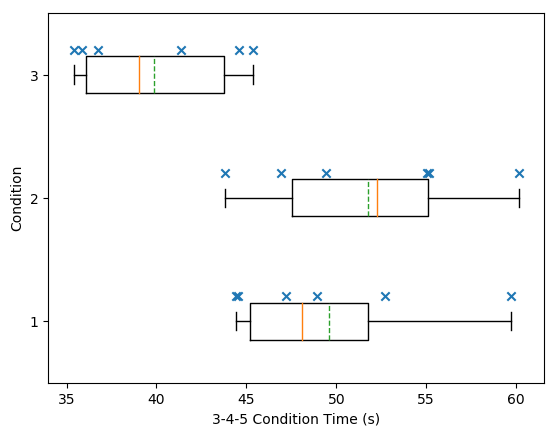

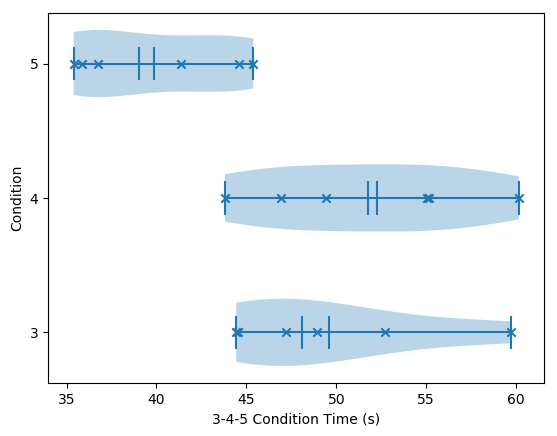

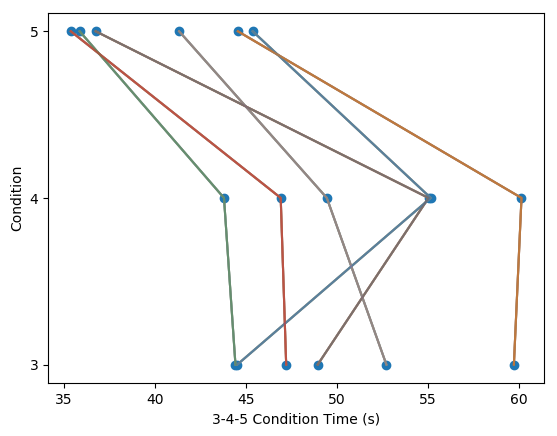

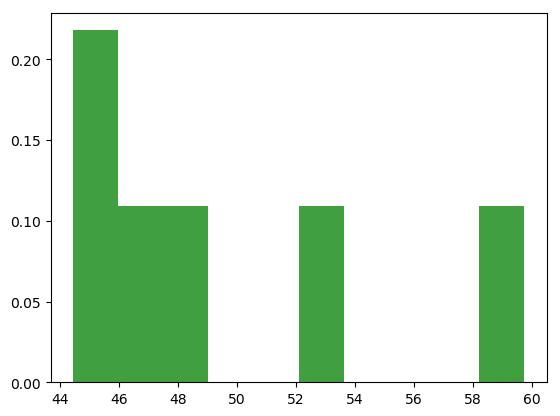

#####
T-Test of Two Samples
Ttest_relResult(statistic=-4.26585071233451, pvalue=0.0009197180146109174)
#####
First Sample
[43.45177198 38.1828981  29.87082055 40.02399322 35.1301605  38.55442528
 45.71774133 40.12674957 30.49851025 61.59737641 21.38364638 25.36738528
 31.80391289 30.49661478]
NormaltestResult(statistic=5.4492324651804935, pvalue=0.06557136204181609)
Second Sample
[45.44935343 52.97823898 39.87062089 47.22149003 43.61650019 58.92837656
 42.39516534 49.59897653 36.4060488  75.0835528  52.64554299 28.71884328
 34.27440451 42.87732566]
NormaltestResult(statistic=5.488997054987121, pvalue=0.06428052778077305)


/anaconda3/envs/leoncv/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


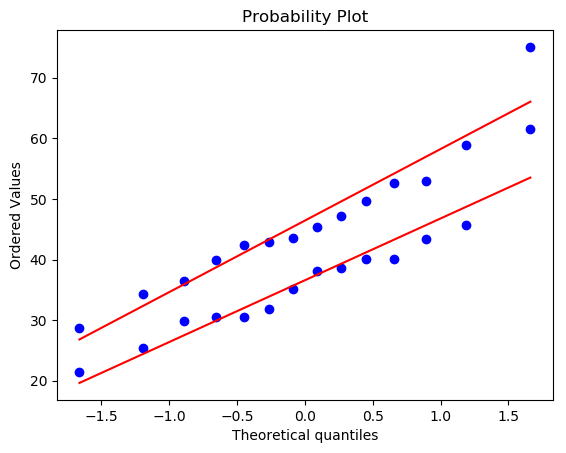

out [1.]


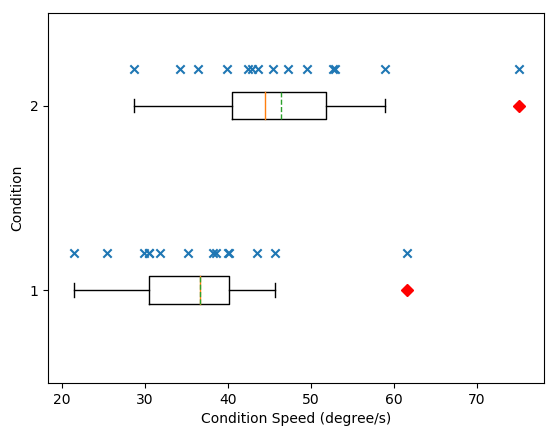

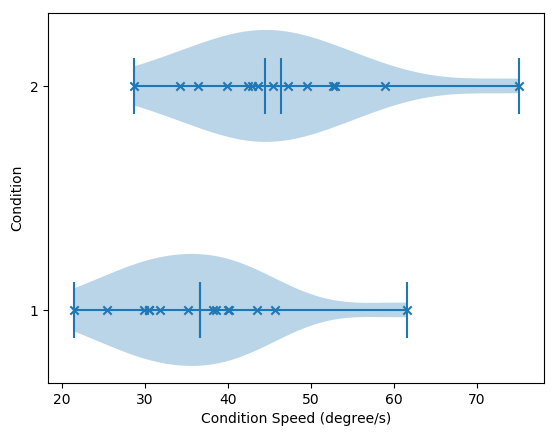

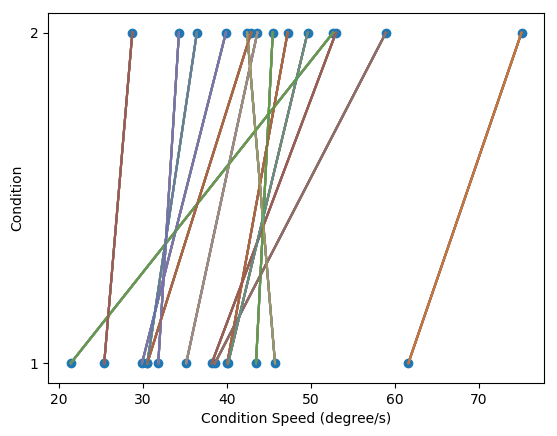

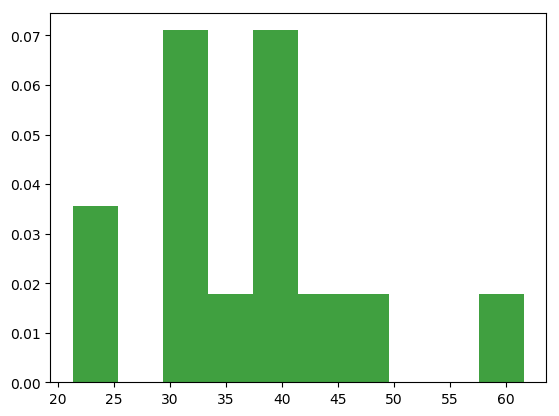

#####
T-Test of Two Samples
Ttest_relResult(statistic=3.5104056066159335, pvalue=0.0038367317400077637)
#####
First Sample
[173.98599999999976, 197.99440000000004, 253.0897999999994, 188.88670000000036, 215.19970000000006, 196.08643999999995, 165.36249999999978, 188.4030000000001, 247.88096, 122.73250000000013, 353.54120000000046, 298.0204666666667, 237.70659999999998, 247.89636666666698]
NormaltestResult(statistic=2.4997461684678903, pvalue=0.2865411611435137)
Second Sample
[166.33899999999994, 142.70009999999982, 189.61329999999964, 160.09660000000008, 173.32889999999992, 128.29133333333345, 178.32221999999996, 152.42250000000033, 207.65779999999975, 100.68782999999988, 143.6019, 263.2418000000001, 220.57276000000005, 176.31696666666673]
NormaltestResult(statistic=2.034753743897282, pvalue=0.3615420685522508)


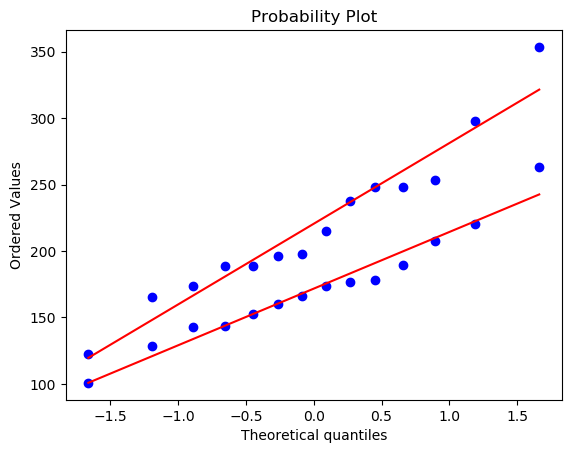

out [1.]


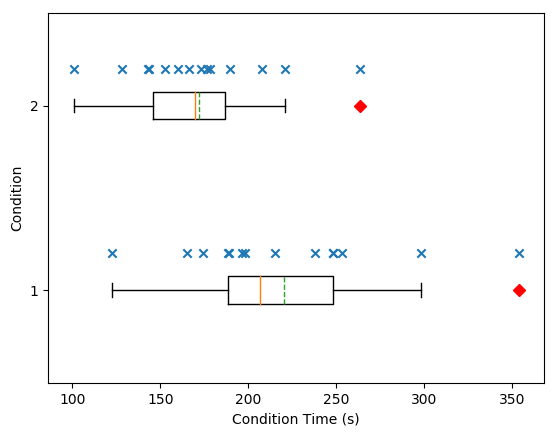

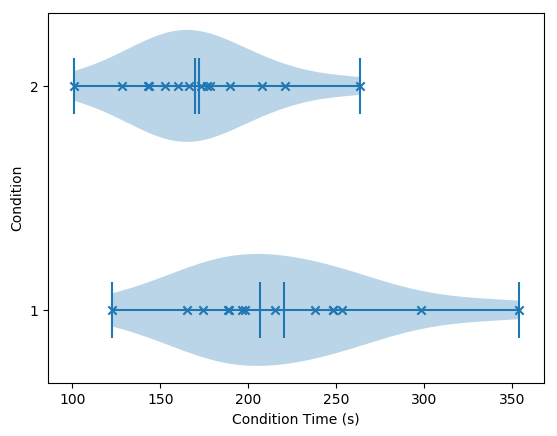

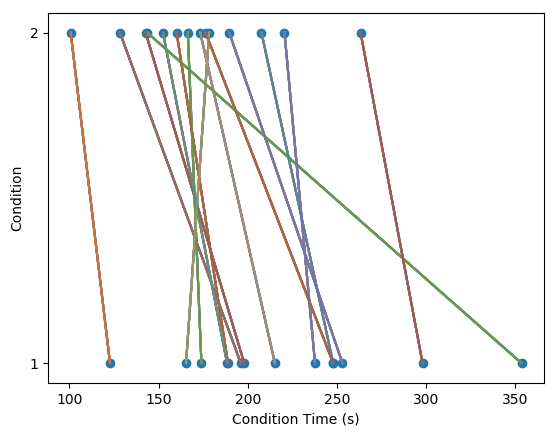

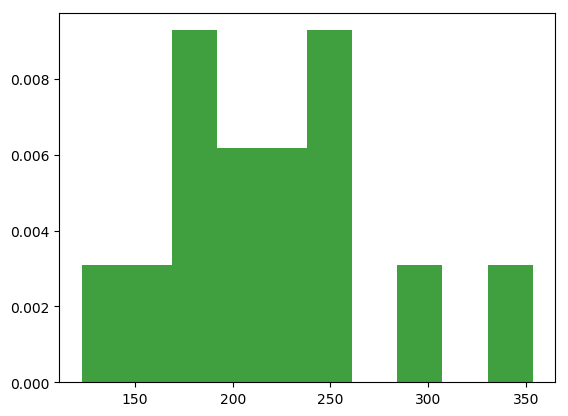

mean of 1st sample
220.48475952380954 881.9390380952382
mean of 2nd sample
171.65664357142853 686.6265742857141
ratio mean of two sample
1.312272297470305
another way 0.7785419905764135
ratio^-1 mean of two sample
0.8005292201343451
another way 1.2844522352090788
(20, 14)
2
data to cal is (20, 14)
(20, 14)
2
data to cal is (20, 14)
#####
T-Test of Two Samples
Ttest_relResult(statistic=-5.465697445587078, pvalue=2.8400148872403438e-05)
#####
First Sample
[21.984146744429093, 25.490087422890817, 33.16358409369952, 43.330733542444136, 45.86893674740401, 40.821871427529686, 32.26264302958631, 31.26691938891841, 39.028310572268715, 53.536185513222826, 58.280952596241825, 53.37384085254827, 41.51282154342831, 20.018175893783983, 32.37596113049027, 29.42930650464593, 41.247065788544965, 47.88782694293196, 38.23642176206339, 30.5952914073576]
NormaltestResult(statistic=0.4020611958072966, pvalue=0.8178874055309598)
Second Sample
[26.068787777054602, 31.33955149145755, 33.41163476197511, 46.958

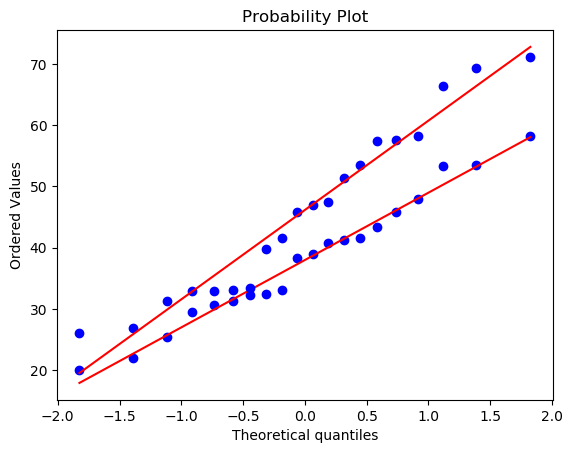

out []


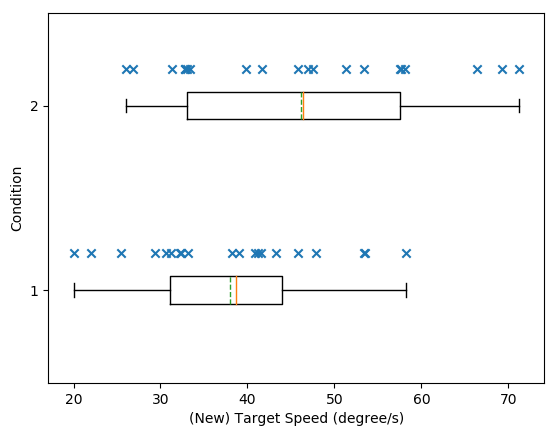

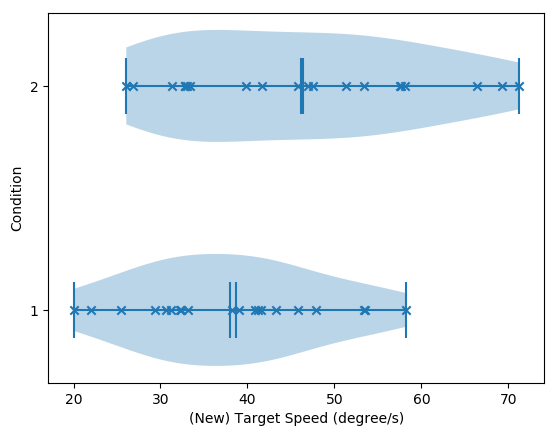

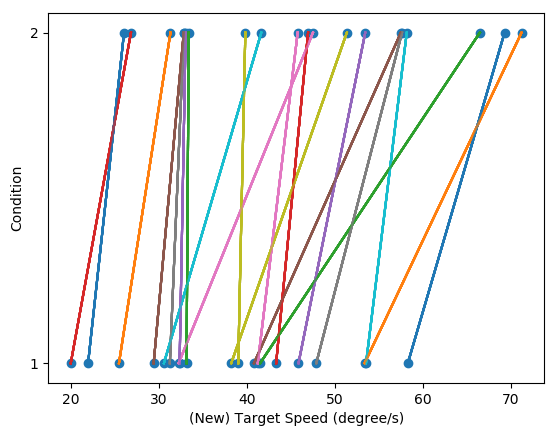

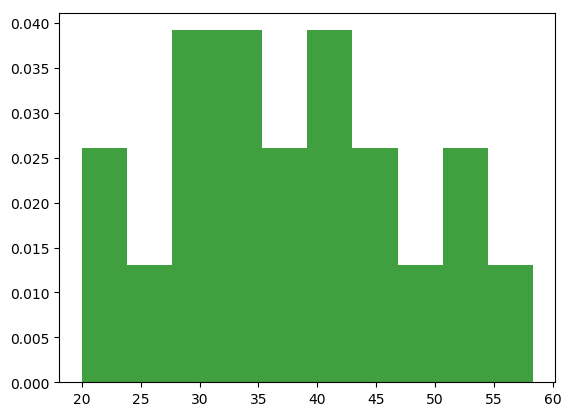

[1.45975071 1.7809     1.98508214 2.13251893 2.61326714 3.57389679
 5.44027714 1.01956821 1.55741786 1.70102036 2.21899643 3.17995714
 4.91231429 1.45521821 1.44425714 2.24179643 2.33334643 2.65550179
 3.70727179 5.05887107]
[1.459750714285704, 1.7808999999999975, 1.9850821428571415, 2.1325189285714425, 2.613267142857139, 3.573896785714278, 5.440277142857154, 1.0195682142857139, 1.5574178571428539, 1.701020357142857, 2.2189964285714305, 3.179957142857147, 4.912314285714297, 1.4552182142857149, 1.4442571428571607, 2.2417964285714223, 2.333346428571432, 2.6555017857142915, 3.7072717857142843, 5.05887107142856]
#####
T-Test of Two Samples
Ttest_relResult(statistic=3.8979778561723437, pvalue=0.000967266812643756)
#####
First Sample
[1.459750714285704, 1.7808999999999975, 1.9850821428571415, 2.1325189285714425, 2.613267142857139, 3.573896785714278, 5.440277142857154, 1.0195682142857139, 1.5574178571428539, 1.701020357142857, 2.2189964285714305, 3.179957142857147, 4.912314285714297, 1.455218

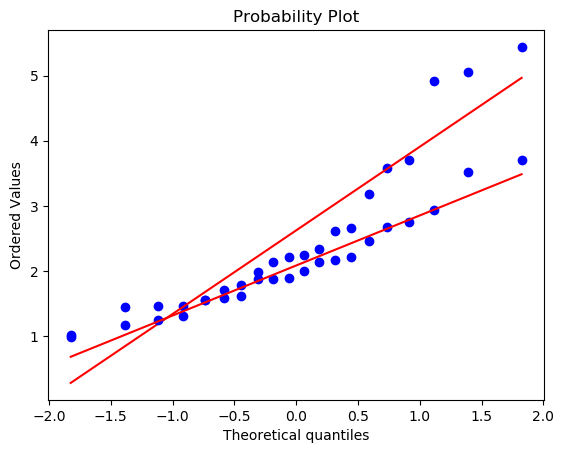

out []


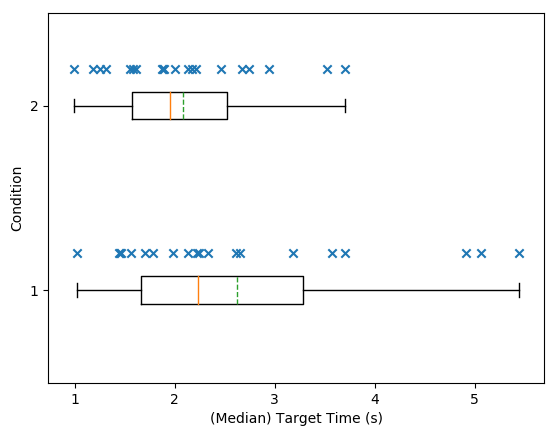

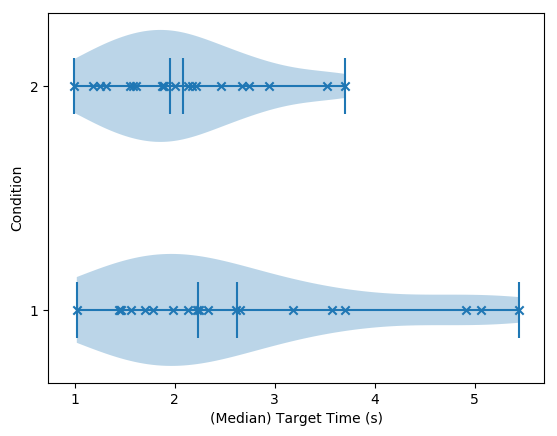

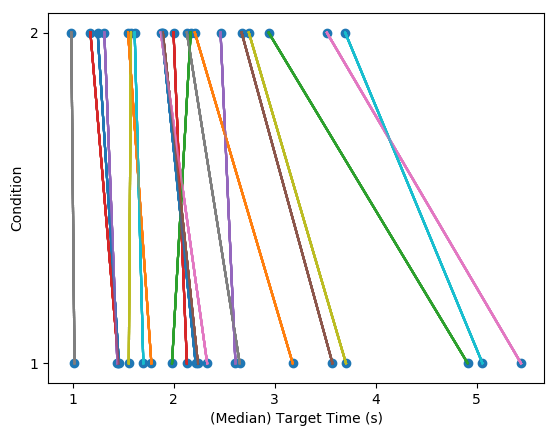

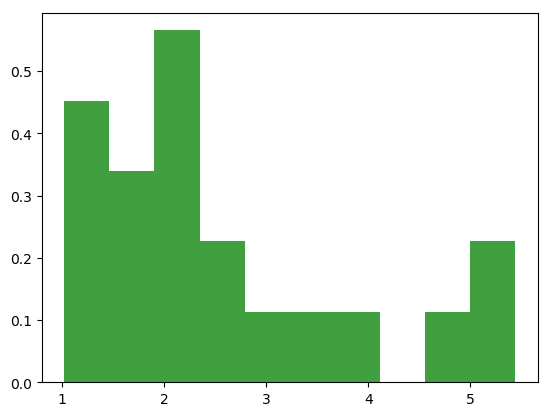

In [151]:
# from pylab import *
plt.style.use('default')

def anova_10x4(input_1, input_2):
    
    new_r_1 = np.array(input_1).T
    new_r_2 = np.array(input_2).T
    
    print("ANOVA of first sample")
    print(stats.f_oneway(new_r_1[0], new_r_1[1], new_r_1[2], new_r_1[3]))

    print("ANOVA of second sample")
    print(stats.f_oneway(new_r_2[0], new_r_2[1], new_r_2[2], new_r_2[3]))
    
    return
    

    

def anova_export(input_1, input2, name):
    with open(name, 'a') as csvFile:
        writer = csv.writer(csvFile)

        for i in range(len(input_1)):
            row = np.array(input_1[i]).flatten()
            writer.writerow(row)

        for i in range(len(input_2)):
            row = np.array(input_2[i]).flatten()
            writer.writerow(row)

        csvFile.close()

def plot_normal_test(input_1, input_2, y_title, input_3=None):
    
    print('#####')
        
    if (input_3 is None):

        print("T-Test of Two Samples")
        print(ttest_rel(input_1, input_2))
        
    else:
        print("One-Way ANOVA of Three Samples")
        print(stats.f_oneway(input_1, input_2, input_3))
        print("T-Test of 1-2")
        print(ttest_rel(input_1, input_2))
        print("T-Test of 2-3")
        print(ttest_rel(input_2, input_3))
        print("T-Test of 1-3")
        print(ttest_rel(input_1, input_3))
        
    if (len(input_1)>8):
    
        print('#####')

        print('First Sample')
        print(input_1)
        print(stats.normaltest(input_1))

        print('Second Sample')
        print(input_2)
        print(stats.normaltest(input_2))
        

        fig0, ax0 = plt.subplots()
        res = stats.probplot(input_1, dist='norm', plot=ax0)
        res = stats.probplot(input_2, dist='norm', plot=ax0)

        export_img("qqplot")
        plt.show()
    

    
    if (input_3 is None):
        plot_data=[input_1, input_2]
        scatter_data =  [[1. for i in input_1], [2. for i in input_2]]
        scatter_data_bias =  [[1.2 for i in input_1], [2.2 for i in input_2]]
        xdata=[1,2]
        toxdata=[1,2]
    else:
        plot_data=[input_1, input_2, input_3]
        scatter_data =  [[1. for i in input_1], [2. for i in input_2], [3. for i in input_3]]
        scatter_data_bias =  [[1.2 for i in input_1], [2.2 for i in input_2], [3.2 for i in input_3]]
        xdata=[1,2,3]
        toxdata=[3,4,5]
    
    fig, ax = plt.subplots()

    r = ax.boxplot(plot_data,  0, 'rD', 0, showmeans=True, meanline=True)
    out = r["fliers"][0].get_data()[1]
    print("out", out)
    
    ax.set_xlabel(y_title)
    ax.set_ylabel('Condition')
    ax.scatter(plot_data, scatter_data_bias,
                marker = "x", alpha=1)
    
    export_img('boxplot')
    plt.show()
    
    
    ## violin
    fig1, ax1 = plt.subplots()
    ax1.violinplot(plot_data, vert=False,
               showmeans=True, showmedians=True, showextrema=True)

    ax1.set_xlabel(y_title)
    ax1.set_ylabel('Condition')
    ax1.scatter(plot_data, scatter_data,
                marker = "x", alpha=1)
    plt.yticks(xdata, toxdata)
    
    export_img('violinplot')
    plt.show()
    
    ## scatter
    fig2, ax2 = plt.subplots()
    ax2.set_xlabel(y_title)
    ax2.set_ylabel('Condition')
    ax2.scatter( plot_data, scatter_data,
                marker = "o", alpha=1)
    for i in np.array(plot_data).T:
        ax2.plot(np.array(plot_data), xdata, alpha=0.5)
    
    plt.yticks(xdata, toxdata)
    
    #export_img('scatterplot')
    plt.show()
    
    fig3, ax3 = plt.subplots()
    ax3.hist(input_1, density=True, facecolor='G', alpha=0.75)
    
    plt.show()
    

    
    
    
    
def cal_mean_of_ratio(input_1, input_2):
     
    ratio = []
    for i in range(len(input_1)):
        ratio.append(input_1[i] / input_2[i])
    ratio_mean = np.mean(ratio)
    print('mean of 1st sample')
    print(np.mean(input_1), 4*np.mean(input_1))
    print('mean of 2nd sample')
    print(np.mean(input_2), 4*np.mean(input_2))

    print('ratio mean of two sample')
    print(ratio_mean)
    print('another way', np.mean(input_2) / np.mean(input_1))

    ratio_0 = []
    for i in range(len(input_1)):
        ratio_0.append(input_2[i] / input_1[i])
    ratio_mean_0 = np.mean(ratio_0)

    print('ratio^-1 mean of two sample')
    print(ratio_mean_0)
    print('another way', np.mean(input_1) / np.mean(input_2))
    
    return
    
    
def angle_ac(lat, lon):
    angle = math.degrees( math.acos( math.cos(math.radians(lat)) * math.cos(math.radians(lon)) ) )
    return angle

def distance_g():    
    distance=[]

    for lat in ['-30', '0', '30']:
        dis=[]
        for lon in ['0', '30', '60', '90', '120', '150', '180']:
            angle = angle_ac(int(lat), int(lon))
            dis.append(angle)
        distance.append(dis)
    
    distance = np.delete(np.array(distance).flatten(), 7)
    
    return distance   # 3*3*7 array{}

def plot_scatter(input_1, input_2):

    distance = distance_g()
    fig, ax = plt.subplots()
    #print(np.array(distance))
    #print(np.array(input_1))
    ax.scatter(np.array(input_1).flatten(), np.array(distance).flatten(), marker = "+")
    ax.scatter(np.array(input_2).flatten(), np.array(distance).flatten(), marker = "o")
    


    
anova_10x4(test1.round_10x4, test2.round_10x4)
#anova_export(test1.round_10x4, test2.round_10x4, 'ANOVA for C-R')

anova_10x4(test3.round_10x4, test4.round_10x4)
anova_10x4(test3.round_10x4, test5.round_10x4)

test1_condition = [np.sum(i) for i in test1.round_10x4]
test2_condition = [np.sum(i) for i in test2.round_10x4]
test3_condition = [np.sum(i) for i in test3.round_10x4]
test4_condition = [np.sum(i) for i in test4.round_10x4]
test5_condition = [np.sum(i) for i in test5.round_10x4]

#print([np.sum(i) for i in test1.round_10x4])
print([np.sum(i) for i in test3.round_10x4])
print([np.sum(i) for i in test3.mean.time_10x4])

total = np.sum(distance_g()) * 4
average_speed_1 = total / test1_condition
average_speed_2 = total / test2_condition

print(4*np.sum(test1.mean.time_3x7_mean))
print(4*np.sum(test2.mean.time_3x7_mean))
#print(Speed(test3.median.time_3_mean))
print(np.sum(test1.mean.time_4_mean))
print(np.sum(LON_KEY_F))

print('##### condition 1')
print(np.mean(test1_condition))
print(total / np.mean(test1_condition))
print('##### condition 2 condition time')
print(np.mean(test2_condition))
print(total / np.mean(test2_condition))
print('##### condition 3 condition time')
print(np.mean(test3_condition))
print(np.sum(LON_KEY_F)*4 / np.mean(test3_condition))
print('##### condition 4 condition time')
print(np.mean(test4_condition))
print(np.sum(LON_KEY_F)*4 / np.mean(test4_condition))
print('##### condition 5 condition time')
print(np.mean(test5_condition))
print(np.sum(LON_KEY_F)*4 / np.mean(test5_condition))

print("##### total/average time ##### averge(total/time)")
print(total / np.mean(test1_condition), np.mean(average_speed_1))
print(total / np.mean(test2_condition), np.mean(average_speed_2))

plot_normal_test(test3.condition_10, test4.condition_10,
                 '3-4-5 Condition Time (s)', test5.condition_10)

plot_normal_test(average_speed_1, average_speed_2, 'Condition Speed (degree/s)')

#plot_scatter(test1_round_mean, test2_round_mean)
plot_normal_test(test1_condition, test2_condition, 'Condition Time (s)')
cal_mean_of_ratio(test1_condition, test2_condition)  

#anova_export(test1.speed_mean_3x7, test1.speed_mean_3x7, 'ANOVA for lat-lon')

#anova_export(test1.speed_mean_10x3x7, test2.speed_mean_10x3x7, 'ANOVA for C-T')

test1_speed_location = np.delete(np.array(test1.speed_mean_3x7).flatten(), 7)
test2_speed_location = np.delete(np.array(test2.speed_mean_3x7).flatten(), 7)

#plot_scatter(test1_speed_location, test2_speed_location)
#plot_normal_test(test1_speed_location, test2_speed_location, 'Target Speed (degree/s)')
#cal_mean_of_ratio(test1_speed_location, test2_speed_location)


plot_normal_test(m_mean(Speed(test1.mean.time_20x10).value),
                 m_mean(Speed(test2.mean.time_20x10).value), '(New) Target Speed (degree/s)')



test1_time_location = np.delete(np.array(test1.time_mean_3x7).flatten(), 7)
test2_time_location = np.delete(np.array(test2.time_mean_3x7).flatten(), 7)

print(test1_time_location)
print(test1.median.time_20_mean)

#plot_normal_test(test1_time_location, test2_time_location, 'Target Time (s)')
plot_normal_test(test1.median.time_20_mean, test2.median.time_20_mean, '(Median) Target Time (s)')
#plot_normal_test(test1.mean.time_20_mean, test2.mean.time_20_mean, '(Mean) Target Time (s)')



52.47123000000003
54.930707404761904
(14, 3, 7)
3
(14, 3, 7)
3
t_all -2.98723476745505 p_all 0.010493329341154363
=====T-stats=====
[[-1.68846201 -2.23200772  0.18989179 -1.15472189 -1.50642465 -2.81978326
  -2.74631353]
 [        nan -0.28833289 -0.36566647 -0.68925355 -2.59724084 -3.15719031
  -3.34698789]
 [-2.44436166 -0.64718105 -1.8586533  -2.12982944 -2.3531119  -3.24719133
  -4.0477128 ]]
=====P-value=====
[[0.11515047 0.04383851 0.8523269  0.26898952 0.15586657 0.01447105
  0.01665474]
 [       nan 0.77763783 0.72049511 0.5027812  0.02212148 0.00756617
  0.00525103]
 [0.02952407 0.52877768 0.08585936 0.0528659  0.03502232 0.00636254
  0.0013823 ]]
0.0013823005520789636
*
*
*
0.005251032567990325
*
0.0063625361854879525
*
*
0.007566170144451381
*
*
0.01447105437724354
*
0.016654737133386548
*
0.022121482498383964
*
0.02952407399531267
*
0.03502231528677458
*
0.04383851229559502
*
0.05286590270833714
0.08585935629014137
0.11515047147247223
0.15586657406581056
0.26898951695070483

/anaconda3/envs/leoncv/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


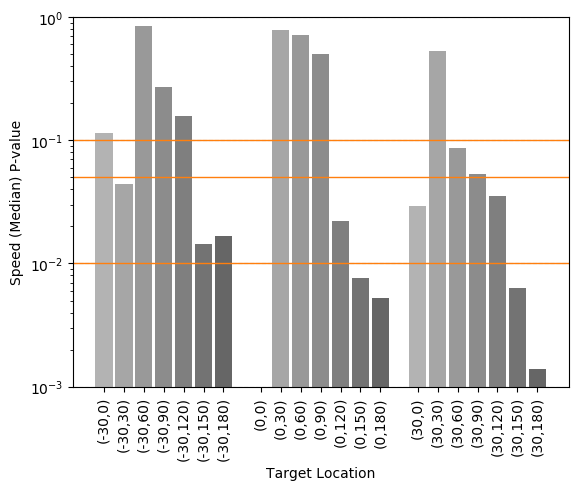

(14, 3, 7)
3
(14, 3, 7)
3
t_all -3.2695665394007416 p_all 0.006094358304165638
=====T-stats=====
[[-1.92711213 -2.22113813 -0.08813302 -0.93035362 -1.48387764 -2.94878455
  -3.25206803]
 [        nan -0.66373876 -0.38312438 -0.99835972 -2.3073945  -4.14509793
  -3.4907272 ]
 [-2.30982942 -0.21227379 -1.70614728 -1.0954942  -2.05351651 -3.90414635
  -4.89109545]]
=====P-value=====
[[7.61058085e-02 4.47250065e-02 9.31114149e-01 3.69143156e-01
  1.61678337e-01 1.12982090e-02 6.30309474e-03]
 [           nan 5.18456011e-01 7.07819173e-01 3.36326129e-01
  3.81318652e-02 1.15172602e-03 3.98427152e-03]
 [3.79598375e-02 8.35185540e-01 1.11740849e-01 2.93181049e-01
  6.07103912e-02 1.81190483e-03 2.94733224e-04]]
0.0002947332241944499
*
*
*
0.0011517260158009131
*
*
*
0.0018119048251775496
*
*
*
0.0039842715198254285
*
*
0.006303094744952271
*
*
0.01129820898168691
*
*
0.03795983747784818
*
0.038131865174251676
*
0.04472500652925264
*
0.06071039122122877
0.07610580847840352
0.11174084927191985


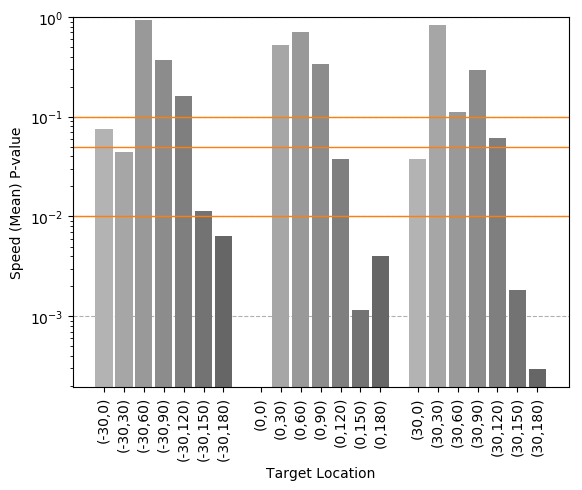

t_all 3.477862928302494 p_all 0.004083812416332323
=====T-stats=====
[[ 1.35196188  0.96707527 -0.78422675  0.68452904  0.63312406  3.12416771
   2.93622168]
 [        nan  0.54139486 -0.36553742  0.69402621  1.91691471  3.0541573
   3.03812351]
 [ 2.27176344  0.50300115  1.79334977  1.51410682  1.64348808  3.62233832
   4.41460665]]
=====P-value=====
[[1.99441331e-01 3.51154179e-01 4.46961913e-01 5.05662396e-01
  5.37631592e-01 8.06280246e-03 1.15742188e-02]
 [           nan 5.97391863e-01 7.20589136e-01 4.99880525e-01
  7.74917558e-02 9.22587974e-03 9.51493889e-03]
 [4.07353569e-02 6.23377197e-01 9.62009171e-02 1.53927287e-01
  1.24235848e-01 3.09673459e-03 6.98620815e-04]]
0.0006986208147946715
*
*
*
0.0030967345916257535
*
*
0.008062802458632067
*
0.009225879736509039
*
*
0.009514938887106071
*
*
0.011574218801442349
*
*
0.04073535691409552
*
0.07749175575232894
0.0962009170768874
0.12423584773773783
0.15392728746150014
0.19944133124906682
0.3511541786666318
0.44696191318360823
0.4

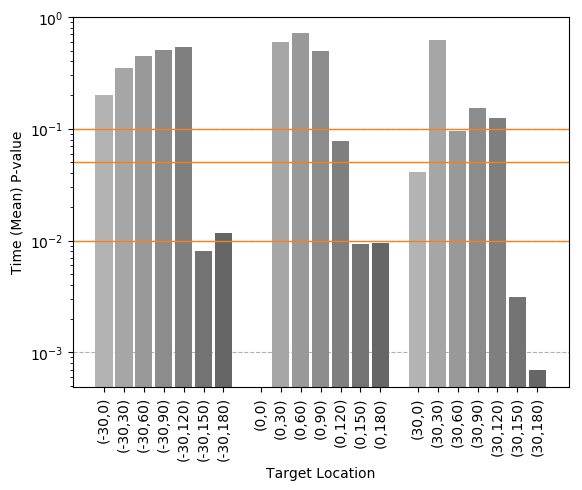

t_all 3.2619475733339263 p_all 0.006184376954534443
=====T-stats=====
[[ 1.27257083  1.03305079 -0.88093023  0.79609516  0.48961939  3.12069697
   2.49855417]
 [        nan  0.32510052 -0.19753229  0.59928249  2.11160046  2.96973109
   2.94278942]
 [ 1.9189251   0.62873465  2.23828522  2.62969836  2.07984375  3.49420375
   4.03994504]]
=====P-value=====
[[0.22546025 0.32041655 0.39435082 0.44027262 0.63256143 0.00811685
  0.02666137]
 [       nan 0.75027768 0.84646613 0.55928431 0.05464893 0.01085243
  0.0114291 ]
 [0.07721671 0.54041329 0.04333411 0.02079933 0.05788952 0.00395779
  0.00140262]]
0.00140262313989837
*
*
*
0.003957794497650981
*
*
0.008116853990122488
*
0.010852431501060687
*
0.0114291011060973
*
*
0.020799326620518966
*
0.026661372144826643
*
0.043334109616453384
*
0.05464892620230433
0.05788951859539244
0.07721671466614664
0.22546025268646283
0.3204165545046229
0.39435082026261514
0.4402726190877283
0.5404132921060165
0.5592843141081383
0.6325614332098092
0.75027767713

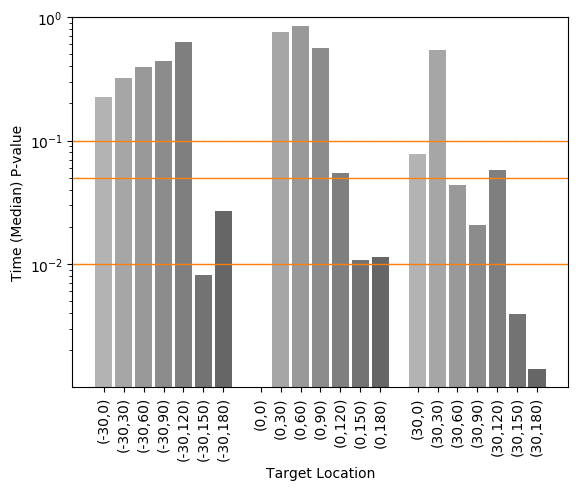

t_all 3.73083041385257 p_all 0.013559351179545213
=====T-stats=====
[[        nan         nan         nan]
 [-0.97553741  0.15251871  1.06194848]
 [-2.39633584 -0.34504641  1.95784865]
 [ 0.13289164  1.08866227  0.57894536]
 [-0.5519058   3.68816758  2.55578176]
 [ 0.49177151  6.31141652  5.36026146]
 [-2.00450091  3.07767425  4.90647703]]
=====P-value=====
[[       nan        nan        nan]
 [0.37409715 0.88474149 0.33683659]
 [0.06190061 0.74410056 0.10758376]
 [0.89946174 0.32597083 0.58772712]
 [0.60477235 0.01417262 0.05090689]
 [0.64370807 0.00147034 0.00303868]
 [0.1013553  0.02754234 0.00444937]]
0.0014703412570073412
*
*
*
0.0030386849158572865
*
*
*
0.004449368648827464
*
*
*
0.014172618424300475
*
*
0.027542344865755623
*
*
0.05090689333685148
0.061900610043756424
0.10135530263180174
0.1075837625011115
0.3259708270249558
0.33683659037126273
0.3740971453256537
0.5877271189533303
0.604772351697905
0.643708065518673
0.7441005575619499
0.8847414850032717
0.8994617427877825
nan


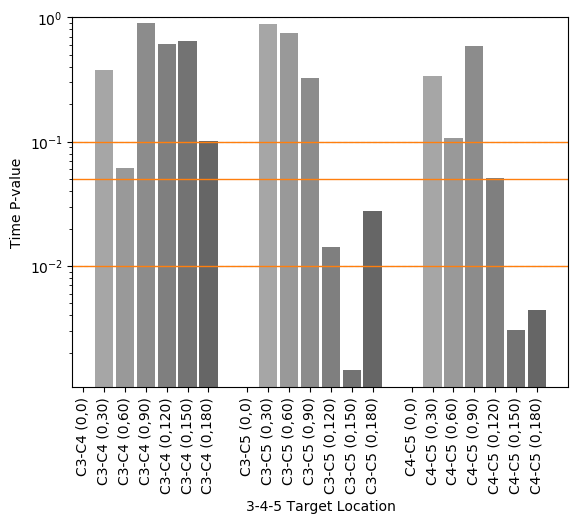

(6, 7, 3)
3
(6, 7, 3)
3
t_all -4.880120478349738 p_all 0.004552522315098133
=====T-stats=====
[[        nan         nan         nan]
 [ 0.9840714  -0.57994008 -1.16251837]
 [ 2.21964199  0.20690552 -1.90187397]
 [-0.3104423  -1.15218484 -0.22404467]
 [ 0.18467626 -3.69464757 -3.57895788]
 [-0.6877617  -5.95418175 -5.82359953]
 [ 1.79938234 -3.70543482 -6.10926136]]
=====P-value=====
[[       nan        nan        nan]
 [0.37027168 0.5871057  0.29749023]
 [0.07716298 0.84424584 0.11558502]
 [0.76874827 0.30133939 0.83158961]
 [0.86073992 0.01407746 0.01589236]
 [0.52220079 0.00191052 0.00210901]
 [0.1318624  0.01392066 0.00170265]]
0.001702650197208696
*
*
*
0.001910517125396092
*
*
*
0.0021090142615040265
*
*
*
0.013920660664611392
*
*
0.014077457967634547
*
*
0.015892361866973848
*
*
0.07716297555214839
0.11558502004021443
0.1318623971289377
0.2974902269688663
0.3013393905814597
0.3702716825831039
0.5222007944289309
0.5871056986322863
0.7687482701807562
0.8315896082137835
0.8442458449

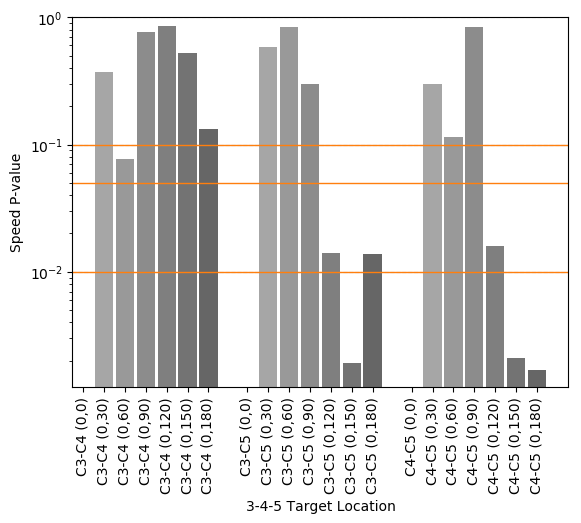

In [152]:
from matplotlib.ticker import NullFormatter
def plot_bar_single(input_mean, ymin=None, ymax=None, x_title=None, y_title=None, z_title=None):
    
    print(np.array(input_mean).shape)
    
    if (np.array(input_mean).shape == (3,7)):
        mean=input_mean
        key1=[-30, 0, 30]
        key2=[0, 30, 60, 90, 120, 150, 180]
        str1='('
        str2=','
        str3=')'
       
    elif (np.array(input_mean).shape == (7,3)):
        mean=np.array(input_mean).T
        key1=['C3-C4', 'C3-C5', 'C4-C5']
        key2=[0, 30, 60, 90, 120, 150, 180]
        str1=''
        str2=' (0,'
        str3=')'
        
    elif (len(input_mean[0])>7):
        mean=input_mean
        key1=[0]
        key2=[1,2,3,4,5,9,10,14,6,12,13,8,11,7]
        str1='User'
        str2='-'
        str3=''

    fig, ax = plt.subplots()
    
    #x = np.arange(3)
    #width = 0.05
    #gap = 0.02
    opacity = 0.1
    #if (len(key1) ==3 or len(key1) ==7):
    #    width = np.abs(key1[0] - key1[1]) / ( len(key2) + 2) / 2
    #else:
    #    width = 5
    wwidth = 10
    width = 10 / (len(key2) + 2) / 2
    gap = width / len(key2)
    offset = (width)
    
    x_axis = []
    x_label = []
    
    for k1 in range(len(key1)):
        for k2 in range(len(key2)):
            x = (wwidth)*k1 + (width)*2*k2 + (gap)*2*k2
            
            plt.bar(x, mean[k1][k2], 2*width, #label=str(key2[k2]
                    color= str(0.7-0.05*k2) )
                    #alpha=1-opacity*k2)
            
            x_axis.append(x)
            x_label.append(str1+str(key1[k1])+str2+str(key2[k2])+str3)
            #x_label.append((key1[k1],key2[k2]))
    
    
    yref1=0.01
    yref2=0.05
    yref3=0.1
    plt.axhline(y=yref1,linewidth=1, color='C1')
    plt.axhline(y=yref2,linewidth=1, color='C1')
    plt.axhline(y=yref3,linewidth=1, color='C1')
        
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    plt.yscale('log')
    ax.set_axisbelow(True)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    if z_title is not None:
        ax.legend(title=z_title)
    #ax.set_ylabel(kind)
    #plt.ylim(0,ymax)
    ax.set_ylim(ymin, ymax)
    plt.xticks(x_axis, x_label, rotation=90)
    
    export_img('barsingle')
    plt.show()


def cal_ttest_3x7(t1, t2):
    tvalue=[]
    pvalue=[]
    for lat in range(len(t1[0])):
        tv=[]
        pv=[]
        for lon in range(len(t1[0][0])):
            all_user_t1=[]
            all_user_t2=[]
            for user in range(len(t1)):
                all_user_t1.append(t1[user][lat][lon])
                all_user_t2.append(t2[user][lat][lon])

            t,p = ttest_rel(all_user_t1, all_user_t2)
            tv.append(t) # *7
            pv.append(p)
        tvalue.append(tv)
        pvalue.append(pv)# *3
    
    d1 =[]
    d2 =[]
    for user in range(len(t1)):
        data_1 = [i for i in np.array(t1[user]).flat if (i!=0)]
        data_2 = [i for i in np.array(t2[user]).flat if (i!=0)]
        d1.append(np.mean(data_1))
        d2.append(np.mean(data_2))
        
    t_all,p_all = ttest_rel(d1, d2)
    print('t_all', t_all, 'p_all', p_all)
    print('=====T-stats=====')
    print(np.array(tvalue))
    print('=====P-value=====')
    print(np.array(pvalue))
    
    return tvalue, pvalue

def fdr(input_data, length):
    fdr=0
    bon=0
    naive=0
    j=0
    for i in sort(input_data):
        print(i)
        if (i<(0.05/length)):
            bon = bon +1
            print("*")
            #print('Bon OK')
        if (i<(0.05)):
            naive = naive +1
            print("*")
            #print('Naïve OK')
        if (i<(0.05/length*(j+1))):
            print("*")
        j = j+1
    
    j=0
    for i in sort(input_data):
        if (i<(0.05/length*(j+1))):
            fdr = fdr +1
            #print("*")
            #print('FDR OK')
        else:
            continue
        j = j+1
        
        
    print("===")
    print("Total: "+ str(length)+" ? "+str(len(input_data)))
    print("Naïve: "+ str(naive))
    print("FDR: "+ str(fdr))
    print("Bon: "+ str(bon))
    print("===")

print(test1.median.time_1_mean)
print(test1.mean.time_1_mean)
#speed_t, speed_p = cal_ttest_3x7(test1.speed_mean_10x3x7, test2.speed_mean_10x3x7)
speed_t, speed_p = cal_ttest_3x7(Speed(test1.median.time_10x3x7).value,
                                 Speed(test2.median.time_10x3x7).value)
#print(speed_t, speed_p)
fdr(np.array(speed_p).flatten(), 20)
plot_bar_single(speed_p, 0, 1,'Target Location', 'Speed (Median) P-value')


speed_t, speed_p = cal_ttest_3x7(Speed(test1.mean.time_10x3x7).value,
                                 Speed(test2.mean.time_10x3x7).value)
#print(speed_t, speed_p)
fdr(np.array(speed_p).flatten(), 20)
plot_bar_single(speed_p, 0, 1,'Target Location', 'Speed (Mean) P-value')



#time_t, time_p = cal_ttest_3x7(test1.time_mean_10x3x7, test2.time_mean_10x3x7)
time_t, time_p = cal_ttest_3x7(test1.mean.time_10x3x7, test2.mean.time_10x3x7)
#print(time_t, time_p)
fdr(np.array(time_p).flatten(), 20)
plot_bar_single(time_p, 0, 1,'Target Location', 'Time (Mean) P-value')


time_t, time_p = cal_ttest_3x7(test1.median.time_10x3x7, test2.median.time_10x3x7)
#print(time_t, time_p)
fdr(np.array(time_p).flatten(), 20)
plot_bar_single(time_p, 0, 1,'Target Location', 'Time (Median) P-value')



#plot_bar_single(time_t)

time_345_t, time_345_p = cal_ttest_3x7(time_10x334, time_10x455)
#print(np.array(time_345_t),'\n', np.array(time_345_p))
fdr(np.array(time_345_p).flatten(), 6)
plot_bar_single(time_345_p, 0, 1,'3-4-5 Target Location', 'Time P-value')



#velocity_334=Speed(time_mean_334,'345')
#print(np.array(velocity_334.value))
#print(np.array(time_10x455).shape)
#velocity_455=Speed(time_10x455,'345')
#print(np.array(velocity_455.value))

speed_345_t, speed_345_p = cal_ttest_3x7(Speed(time_10x334, '345').value, Speed(time_10x455, '345').value)
fdr(np.array(speed_345_p).flatten(), 6)
plot_bar_single(speed_345_p, 0, 1,'3-4-5 Target Location', 'Speed P-value')




[]
[]
[]
[]
(3, 7, 14)
3
data to cal is (3, 7, 14)
[[22.93886082 26.60856314 34.35633208 44.19597531 46.9120172  42.15448647
  34.01535583]
 [ 0.         32.40130323 39.91114467 56.70870622 58.63430123 55.80477672
  43.19524262]
 [22.29945178 33.25294044 31.42078926 42.87162841 48.73483682 40.4102941
  32.67262939]]
(3, 7)
2
[[20.55145424 23.25207598 32.41230795 42.20361132 44.25835552 38.77850598
  27.57212474]
 [ 0.         29.42422055 38.52530631 52.9094197  54.07850074 47.17044704
  36.64260663]
 [20.61546489 28.67191782 28.70068527 38.5712121  43.55444492 37.38338754
  29.65088414]]
(3, 7, 14)
3
data to cal is (3, 7, 14)
(3, 7, 14)
3
data to cal is (3, 7, 14)
(3, 7, 14)
3
data to cal is (3, 7, 14)
(3, 7, 14)
3
data to cal is (3, 7, 14)


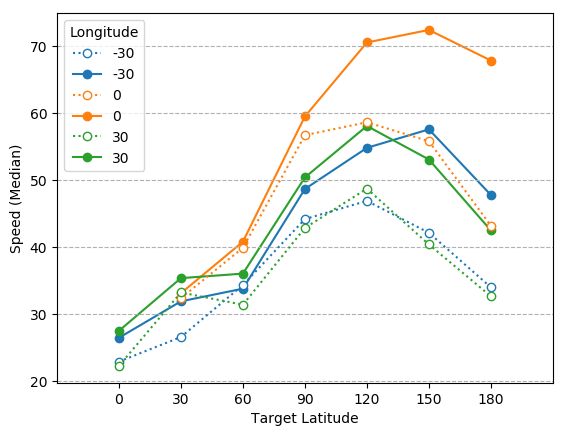

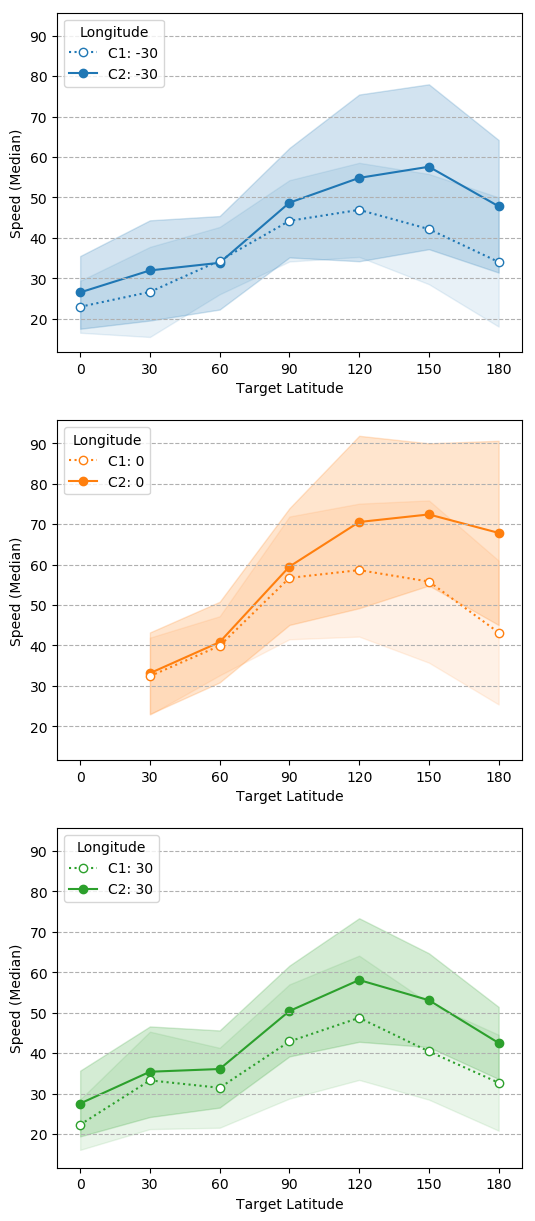

(3, 7)
#####
ratio [[1.15496913 1.2000078  0.9842892  1.10149713 1.16854579 1.36583811
  1.4049218 ]
 [1.         1.02267781 1.02289492 1.04923113 1.20292831 1.29746552
  1.5705171 ]
 [1.23451485 1.06427805 1.14779547 1.17576928 1.19173808 1.31356177
  1.30084437]]
log [[ 0.20785429  0.26304378 -0.02284583  0.13946573  0.22471427  0.4497865
   0.49048983]
 [ 0.          0.03235171  0.03265795  0.06933251  0.26655067  0.3756962
   0.65123966]
 [ 0.30394419  0.08987512  0.19886559  0.23360499  0.2530672   0.39348405
   0.37944837]]
#####
RATIO!!
remove one


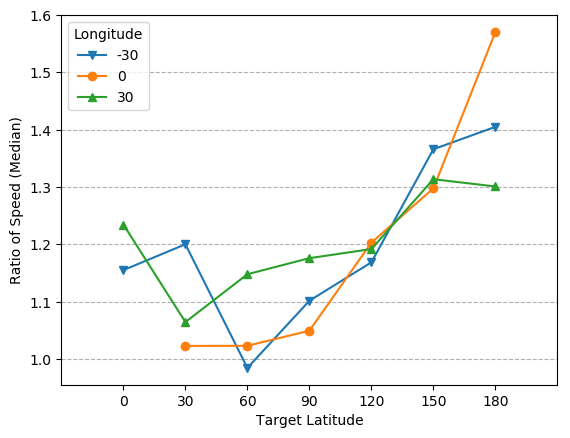

LOG!!
remove zero


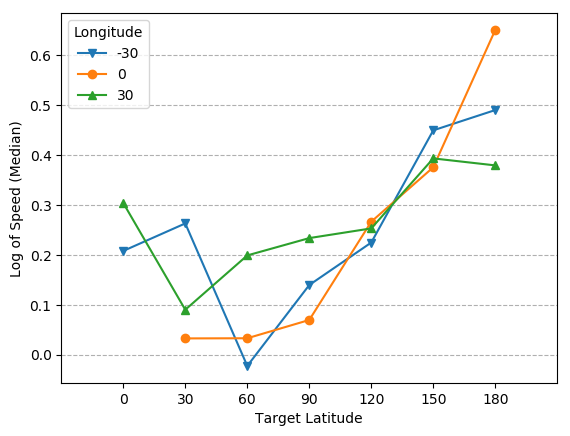

(3, 7, 14)
3
data to cal is (3, 7, 14)
(3, 7, 14)
3
data to cal is (3, 7, 14)
(3, 7, 14)
3
data to cal is (3, 7, 14)
(3, 7, 14)
3
data to cal is (3, 7, 14)


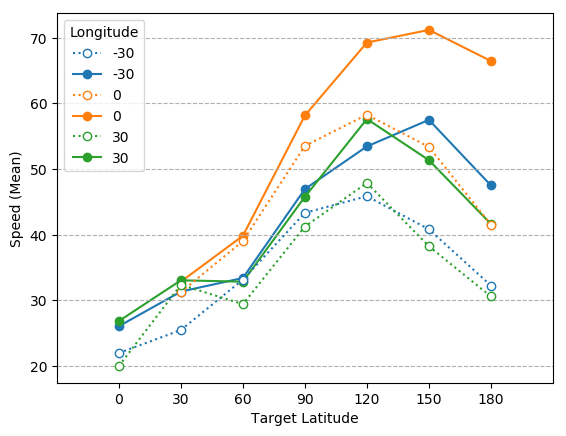

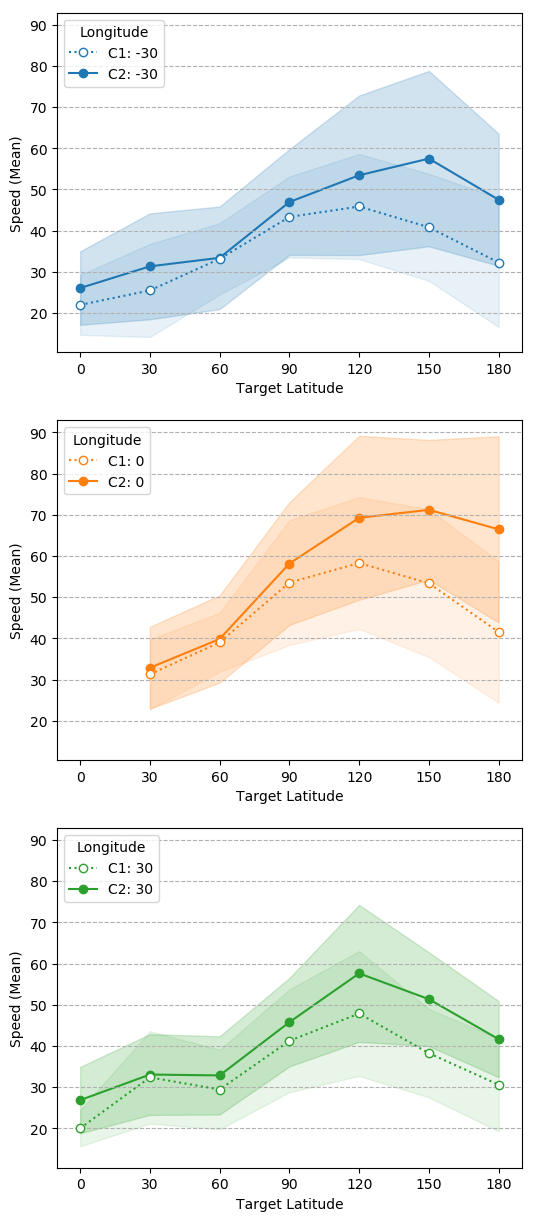

(3, 7)
#####
ratio [[1.18579939 1.22947995 1.00747961 1.08372475 1.16526666 1.40840874
  1.47260456]
 [1.         1.05079347 1.02068043 1.08637955 1.18846221 1.33382325
  1.60090924]
 [1.34143496 1.0211279  1.11617599 1.10983866 1.20328104 1.34313683
  1.36122435]]
log [[0.24585996 0.29804821 0.01075064 0.11599838 0.22066014 0.49406609
  0.55837007]
 [0.         0.07147914 0.02953124 0.11952823 0.24909603 0.41556751
  0.67889152]
 [0.42377711 0.03016357 0.15856451 0.15034996 0.26697364 0.42560628
  0.44490486]]
#####
RATIO!!
remove one


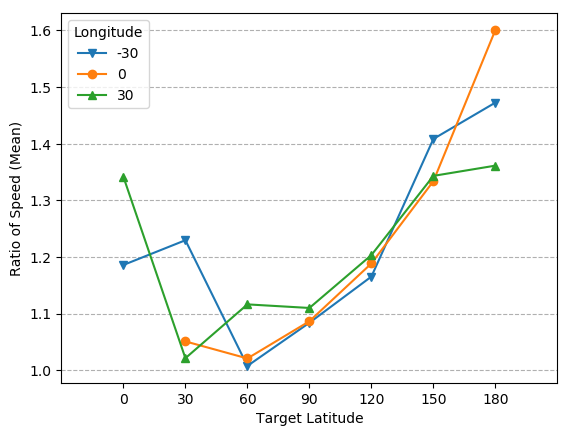

LOG!!
remove zero


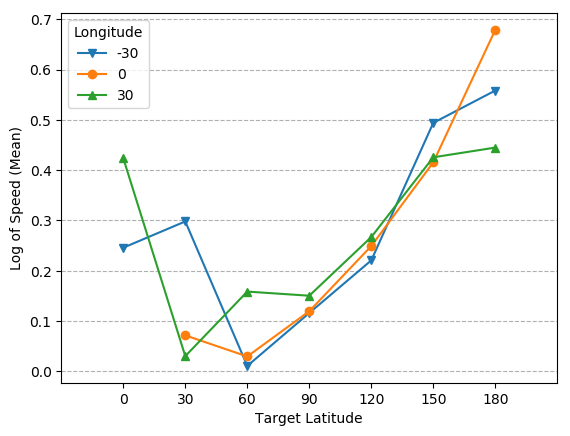

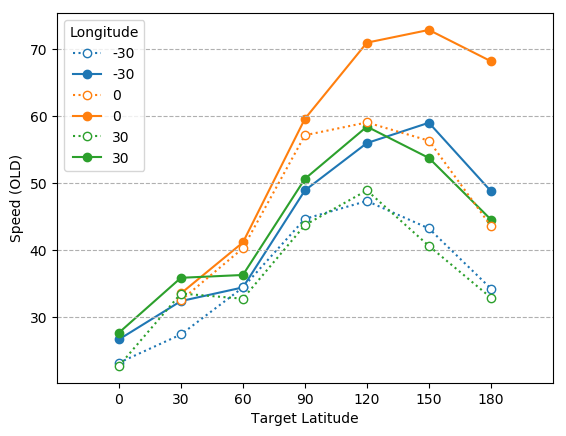

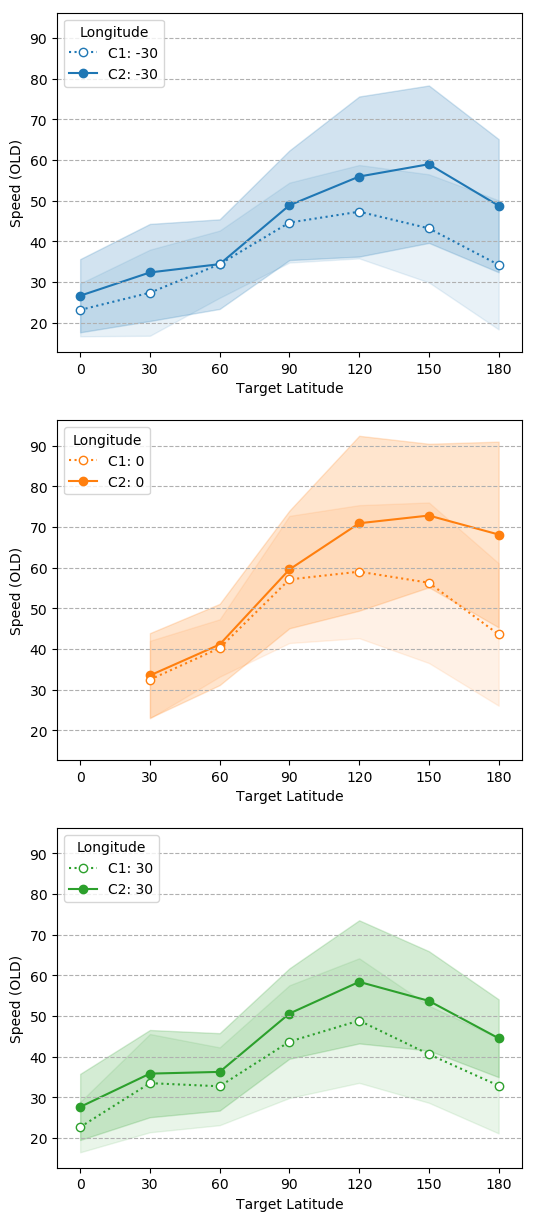

(3, 7)
#####
ratio [[1.15041514 1.18201271 1.0003058  1.09529845 1.18272287 1.36511552
  1.42489023]
 [1.         1.03162142 1.02146775 1.04297446 1.20166133 1.29361723
  1.56388077]
 [1.21831507 1.06994926 1.10819168 1.157949   1.19467194 1.3232691
  1.35461587]]
log [[2.02154568e-01 2.41245545e-01 4.41107084e-04 1.31324032e-01
  2.42112068e-01 4.49023037e-01 5.10850787e-01]
 [0.00000000e+00 4.49136346e-02 3.06436549e-02 6.07038247e-02
  2.65030351e-01 3.71410797e-01 6.45130524e-01]
 [2.84887283e-01 9.75423864e-02 1.48207444e-01 2.11571709e-01
  2.56614510e-01 4.04106481e-01 4.37883803e-01]]
#####
RATIO!!
remove one


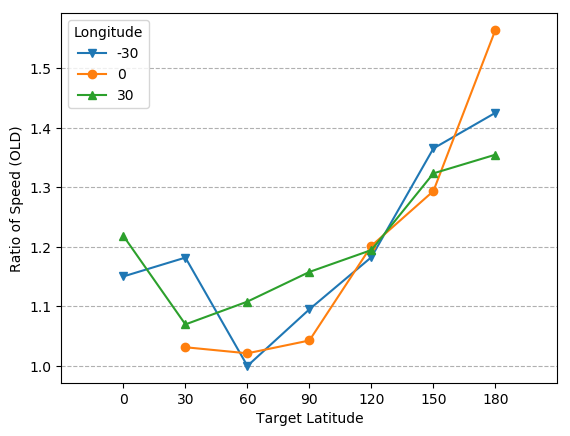

LOG!!
remove zero


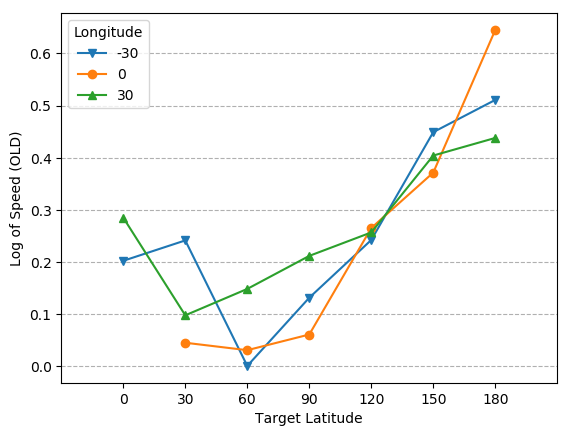

(3, 7)
2
(3, 7)
2


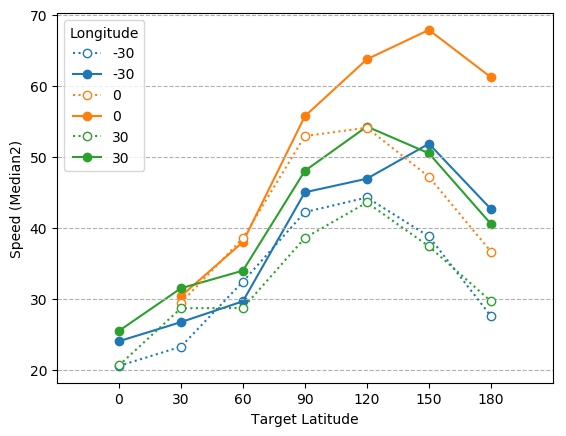

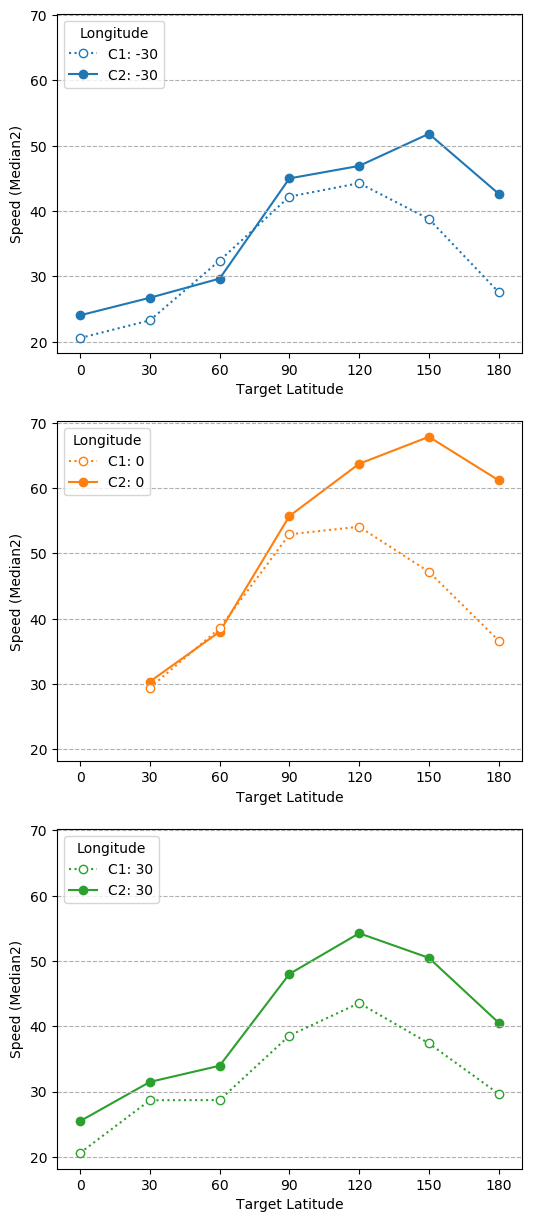

(3, 7)
#####
ratio [[1.16913572 1.14886715 0.91472267 1.06604778 1.05977276 1.3363825
  1.54639701]
 [1.         1.03176739 0.98620462 1.0529467  1.17820704 1.43826429
  1.66971974]
 [1.23606031 1.09792257 1.18324241 1.24482606 1.24546711 1.35021885
  1.36735128]]
log [[ 0.22544242  0.20021198 -0.12859368  0.0922721   0.08375494  0.41833299
   0.62891075]
 [ 0.          0.04511775 -0.02004108  0.07443241  0.23659308  0.5243288
   0.73960597]
 [ 0.30574913  0.13477631  0.24274567  0.31594417  0.31668692  0.43319327
   0.45138392]]
#####
RATIO!!
remove one


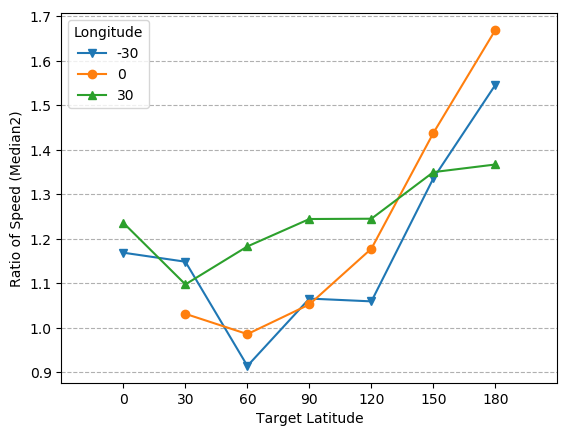

LOG!!
remove zero


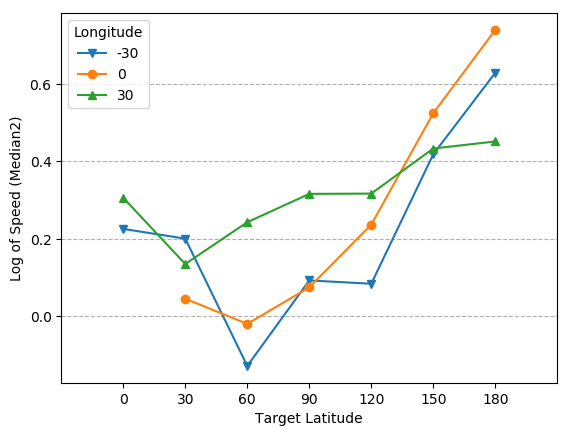

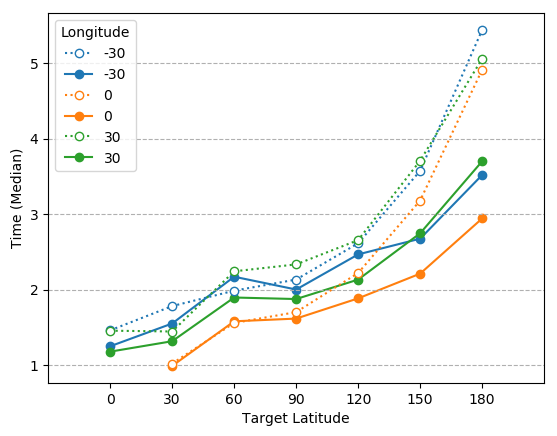

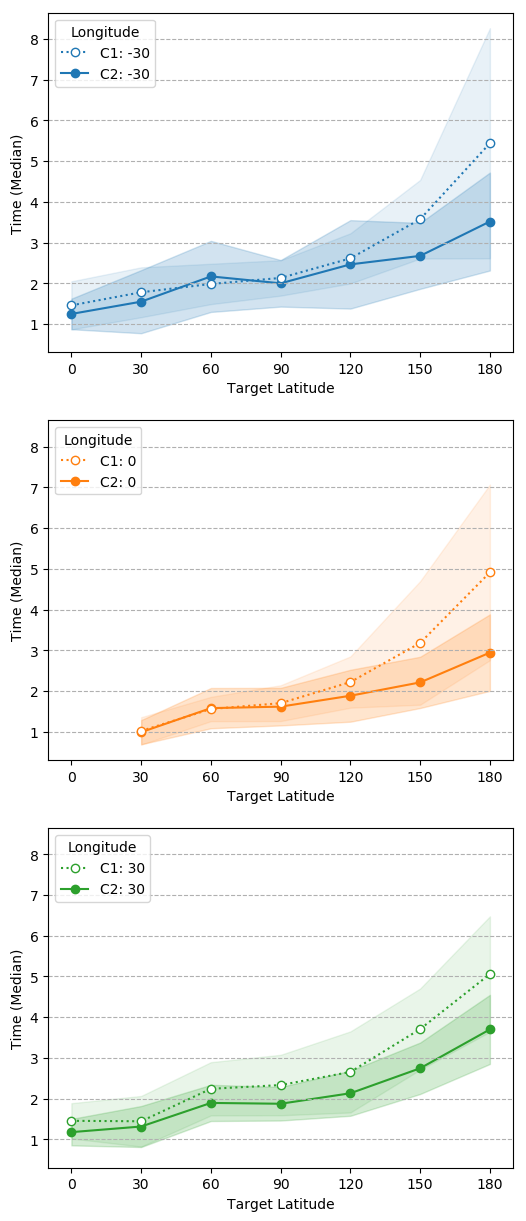

(3, 7)
#####
ratio [[0.85533269 0.87042266 1.09322752 0.93804426 0.94359852 0.74828876
  0.64666447]
 [1.         0.96921071 1.01398836 0.94971569 0.84874726 0.69528251
  0.5989029 ]
 [0.80902201 0.91081104 0.84513536 0.80332508 0.80291161 0.74062068
  0.73134096]]
log [[-0.22544242 -0.20021198  0.12859368 -0.0922721  -0.08375494 -0.41833299
  -0.62891075]
 [ 0.         -0.04511775  0.02004108 -0.07443241 -0.23659308 -0.5243288
  -0.73960597]
 [-0.30574913 -0.13477631 -0.24274567 -0.31594417 -0.31668692 -0.43319327
  -0.45138392]]
#####
RATIO!!
remove one


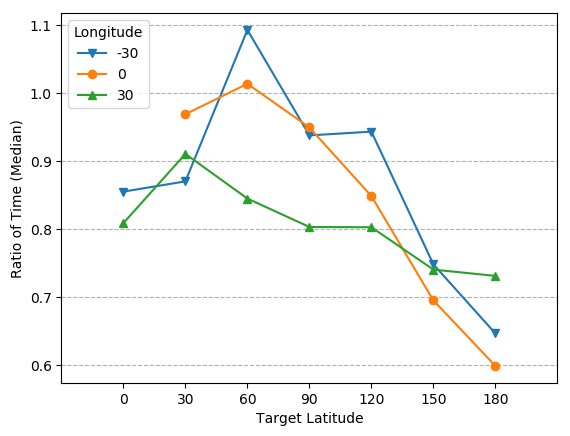

LOG!!
remove zero


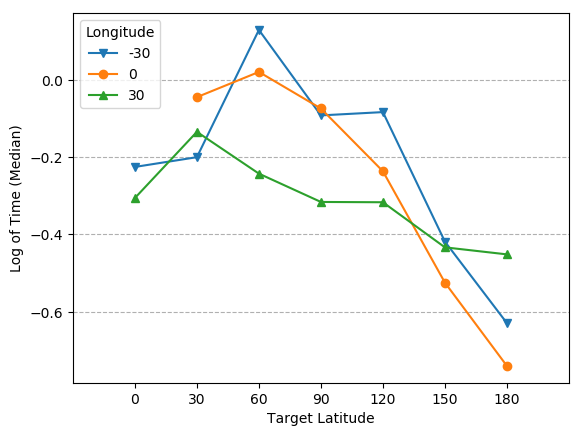

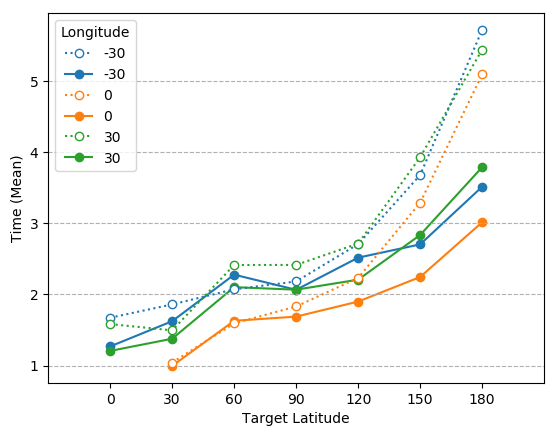

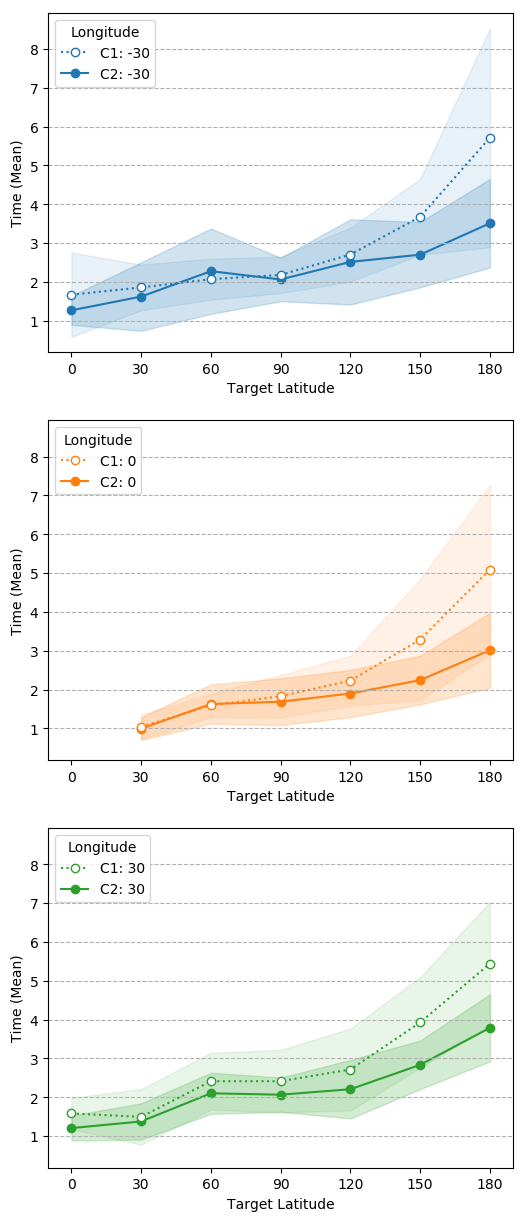

(3, 7)
#####
ratio [[0.75883312 0.87297719 1.09942897 0.94622594 0.92971982 0.73500844
  0.61446326]
 [1.         0.95401811 1.02303662 0.92218823 0.85114734 0.68253641
  0.59187685]
 [0.76153885 0.92110537 0.87098394 0.8559094  0.81290321 0.72180276
  0.69609722]]
log [[-0.39814545 -0.19598414  0.1367544  -0.07974339 -0.10513209 -0.44416727
  -0.70260135]
 [ 0.         -0.06791144  0.03285779 -0.11686685 -0.2325192  -0.55102208
  -0.75663107]
 [-0.39301046 -0.1185619  -0.19928197 -0.22447    -0.29884452 -0.47032344
  -0.52263928]]
#####
RATIO!!
remove one


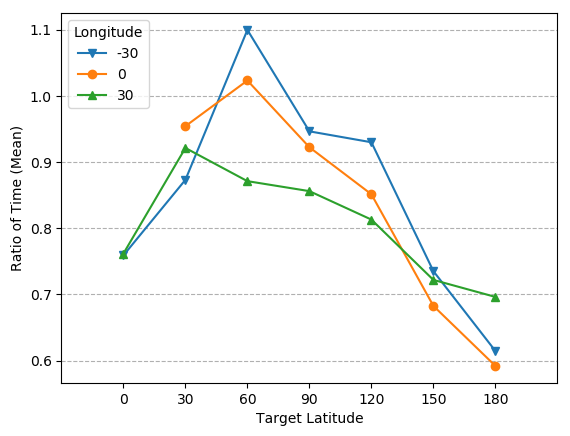

LOG!!
remove zero


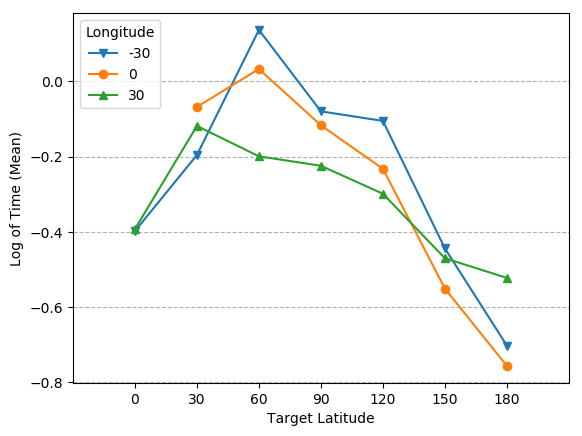

In [153]:
def plot_bar_dual_any(y_title, input_mean_1, input_mean_2, input_std_1=None, input_std_2=None):
    
    key1, key2 = which_axis(input_mean_1)
    
    mean_1 = input_mean_1
    mean_2 = input_mean_2
    
    std_1 = input_std_1 if (input_std_1 is not None) else np.zeros_like[mean_1]
    std_2 = input_std_2 if (input_std_2 is not None) else np.zeros_like[mean_2]


    plt.figure(1, figsize = (12,16))  
    fig, ax = plt.subplots()
    
    #plt.subplot(2, 1, 1)
    #ax = plt.gca()
    
    #x = np.arange(3)
    #width = 0.05
    #gap = 0.02
    opacity = 0.1
    
    width = np.abs(key1[0] - key1[1]) / ( len(key2) + 2) / 2
    gap = width / len(key2)
    offset = (width)
    
    x_axis = []
    x_label = []
    
    for k1 in range(len(key1)):
        for k2 in range(len(key2)):
            x = key1[k1] + (width)*2*k2 + (gap)*2*k2
            
            plt.bar(x , mean_1[k1][k2], width, #label=str(key2[k2]
                    color="C0", alpha=1-opacity*k2, yerr=std_1[k1][k2])
            plt.bar(x + offset , mean_2[k1][k2], width,
                    color="C3", alpha=1-opacity*k2, yerr=std_2[k1][k2])
            
            x_axis.append(x+0.5*offset)
            #x_label.append('('+str(key1[k1])+','+str(key2[k2])+')')
            x_label.append((key1[k1],key2[k2]))
    
    plt.bar(1,0,1, color="C0", label="C1")
    plt.bar(2,0,1, color="C3", label="C2")
        
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.set_ylabel(y_title)
    #ax.set_ylabel(kind)
    #plt.ylim(0,ymax)
    ax.legend(title="Condition")
    
    plt.xticks(x_axis, x_label, rotation=90)
    
    export_img('barplot')
    plt.show()
    

    

def plot_line_dual_any(y_title, input_mean_1, input_mean_2, input_std_1=None, input_std_2=None): 
    
    key1, key2 = which_axis(input_mean_1)
    
    #std_0 = np.zeros_like[input_mean_1]
    
    std_1 = input_std_1 if (input_std_1 is not None) else np.zeros_like(input_mean_1)
    std_2 = input_std_2 if (input_std_2 is not None) else np.zeros_like(input_mean_2)
    
    mean_1 = input_mean_1
    mean_2 = input_mean_2
    
    fig0, ax0 = plt.subplots()


    #if (np.array(mean_1).shape == (7,3)):
    
    m_style = dict(markerfacecolor='white', markeredgewidth =2)
    
    for k1 in range(len(key1)):
        if (0 in mean_1[k1]):
            data_1= list(mean_1[k1])[:]
            data_2= list(mean_2[k1])[:]
            data_1.remove(0.)
            data_2.remove(0.)
            kkey = key2[:]
            kkey.remove(0)

            plt.plot(kkey, data_1, ':o', color = 'C'+ str(k1), 
                     markerfacecolor='white', markeredgewidth =1, zorder=5,
                     label=str(key1[k1]))
            plt.plot(kkey, data_2, '-o', color = 'C'+ str(k1), zorder=0,
                     label=str(key1[k1]))
        else:
            plt.plot(key2, mean_1[k1], ':o', color = 'C'+ str(k1),
                     markerfacecolor='white', markeredgewidth =1, zorder=5,
                     label=str(key1[k1]))
            plt.plot(key2, mean_2[k1], '-o', color = 'C'+ str(k1), zorder=0,
                     label=str(key1[k1]))
        
        
        
    ax0 = plt.gca()
    ax0.yaxis.grid(True, linestyle = "--")
    ax0.legend(title="Longitude", loc=2)
    ax0.set_ylabel(y_title)
    ax0.set_xlabel('Target Latitude')
    plt.xticks(key2, key2)
    plt.xlim(key2[0]-30, key2[-1]+30)
    

    
    
    if (1<5):
        fig, axs = plt.subplots(3,1,sharey=True, figsize=(6,15))
        for k1 in range(len(key1)):
            #fig, ax =plt.subplots(sharey=True)
            
            if (input_std_1 is not None):
                errmax_1 = np.array(remove_zero(mean_1[k1])) + np.array(remove_zero(std_1[k1]))
                errmin_1 = np.array(remove_zero(mean_1[k1])) - np.array(remove_zero(std_1[k1]))   
                errmax_2 = np.array(remove_zero(mean_2[k1])) + np.array(remove_zero(std_2[k1]))
                errmin_2 = np.array(remove_zero(mean_2[k1])) - np.array(remove_zero(std_2[k1]))
                         
            key_temp = remove_zero(key2) if (0 in mean_1[k1]) else key2

            axs[k1].plot(key_temp, remove_zero(mean_1[k1]),':o', zorder=5,
                         color = 'C'+ str(k1),
                     markerfacecolor='white', markeredgewidth =1,
                     label='C1: '+str(key1[k1]))
            if (input_std_1 is not None):
                axs[k1].fill_between(key_temp, errmin_1, errmax_1,
                             alpha=0.1, color = 'C'+ str(k1), edgecolor='')

            axs[k1].plot(key_temp, remove_zero(mean_2[k1]), '-o', zorder=1,
                         color = 'C'+ str(k1), label='C2: '+str(key1[k1]))
            if (input_std_1 is not None):
                axs[k1].fill_between(key_temp, errmin_2, errmax_2,
                             alpha=0.2, color = 'C'+ str(k1), edgecolor='')

            #axs = plt.gca()
            axs[k1].yaxis.grid(True, linestyle = "--")
            axs[k1].legend(title="Longitude", loc=2)
            axs[k1].set_xlabel('Target Latitude')
            axs[k1].set_ylabel(y_title)
            axs[k1].set_xticks(key2)
            
            axs[k1].set_xlim(key2[0]-10, key2[-1]+10)
            #ax.set_ylim(0, 6)
    
    
    
            
    if (6<5):
        for k1 in range(len(key1)):
            fig,ax=plt.subplots()
            if (1 in ratio_c[k1]):
                data_1= list(ratio_c[k1])[:]
                data_1.remove(1.)
                kkey = key2[:]
                kkey.remove(0)

                plt.plot(kkey, data_1, '-o', color = 'C'+ str(k1), label=str(key1[k1]))
            else:
                plt.plot(key2, ratio_c[k1], '-o', color = 'C'+ str(k1), label=str(key1[k1]))

            ax = plt.gca()
            ax.yaxis.grid(True, linestyle = "--")
            ax.legend(title="Longitude", loc=2)
            ax.set_xlabel('Target Latitude')
            ax.set_ylabel('Time')
            plt.xticks(key2, key2)
            plt.xlim(key2[0]-30, key2[-1]+30)
            ax.set_ylim(bottom=0, top=2)
    
    export_img('trio')
    plt.show()
    
def plot_line_simple_3x7(input_data, yy_title, data_type=None):
    
    key1, key2 = which_axis(input_data)

    if (data_type == 'ratio'):
        data_to_delete = 1.
        print('RATIO!!')
    elif (data_type == 'log'):
        data_to_delete = 0
        print('LOG!!')
    else:
        data_to_delete = 100

    fig,ax = plt.subplots()
    
    marks=['v', 'o', '^']

    for k1 in range(len(key1)):

        if (data_to_delete in input_data[k1]):
            key_temp = remove_zero(key2)
            if (data_type == 'ratio'):
                new_data = remove_one(input_data[k1])
                print('remove one')
            elif (data_type == 'log'):
                new_data = remove_zero(input_data[k1])
                print('remove zero')
        else:
            key_temp = key2
            new_data = input_data[k1][:]

        plt.plot(key_temp, new_data, '-'+marks[k1], color = 'C'+ str(k1), label=str(key1[k1]))


    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.legend(title="Longitude", loc=2)
    ax.set_xlabel('Target Latitude')
    ax.set_ylabel(yy_title)
    plt.xticks(key2, key2)
    plt.xlim(key2[0]-30, key2[-1]+30)
    #ax.set_ylim(0.4, 1.2)
    export_img('line')
    plt.show()
    
    

def plot_ratio(y_title, input_mean_1, input_mean_2):
    print(np.array(input_mean_1).shape)
    ratio, log = User.cal_ratio(input_mean_1, input_mean_2)
    ##########
    print('#####')
    print('ratio', np.array(ratio))
    print('log', np.array(log))
    print('#####')
    #########  
    
    plot_line_simple_3x7(ratio, 'Ratio of '+ y_title, 'ratio')
    plot_line_simple_3x7(log, 'Log of '+ y_title, 'log')
    
    
    
def plot_line_dual_any_plus(y_title, input_mean_1, input_mean_2, input_std_1=None, input_std_2=None):
    plot_line_dual_any(y_title, input_mean_1, input_mean_2, input_std_1, input_std_2)
    plot_ratio(y_title, input_mean_1, input_mean_2)
    
    
    
#############

print(test1.time_mean_lat)
print(test2.time_mean_lat)
print(test1.time_mean_lon)
print(test2.time_mean_lon)

#print(Exp.cal_mean_3_old(test1.time_mean_3x7))
#print(Exp.cal_mean_3(test1.time_mean_10x3x7))
#print(Exp.cal_mean_3(test2.time_mean_10x3x7))

#print(Exp.cal_mean_7_old(test1.time_mean_3x7))
#print(Exp.cal_mean_7(test1.time_mean_10x3x7))
#print(Exp.cal_mean_7(test2.time_mean_10x3x7))

#print(np.array(test1.time_mean_3x7))
#print(np.array(test2.time_mean_3x7))

if (False):
    print('test1')
    print(test1.speed_mean_3x7)
    print(test1.speed_std_3x7)

    print('test2')
    print(test2.speed_mean_3x7)
    print(test2.speed_std_3x7)



print(np.array(m_mean(Speed(test1.median.time_3x7x10).value)))
print(Speed(test1.median.time_3x7_mean))

plot_line_dual_any_plus('Speed (Median)', m_mean(Speed(test1.median.time_3x7x10).value),
                        m_mean(Speed(test2.median.time_3x7x10).value), 
                        m_std(Speed(test1.median.time_3x7x10).value),
                        m_std(Speed(test2.median.time_3x7x10).value))
plot_line_dual_any_plus('Speed (Mean)', m_mean(Speed(test1.mean.time_3x7x10).value),
                        m_mean(Speed(test2.mean.time_3x7x10).value), 
                        m_std(Speed(test1.mean.time_3x7x10).value),
                        m_std(Speed(test2.mean.time_3x7x10).value))
   
#plot_bar_dual_any('Speed', test1.speed_mean_3x7, test2.speed_mean_3x7,
#                  test1.speed_std_3x7, test2.speed_std_3x7)
plot_line_dual_any_plus('Speed (OLD)', test1.speed_mean_3x7, test2.speed_mean_3x7,
                   test1.speed_std_3x7, test2.speed_std_3x7)
plot_line_dual_any_plus('Speed (Median2)', Speed(test1.median.time_3x7_mean).value,
                        Speed(test2.median.time_3x7_mean).value)

#plot_bar_dual_any('Time', test1.time_mean_3x7, test2.time_mean_3x7,
#                  test1.time_std_3x7, test2.time_std_3x7)
#plot_line_dual_any_plus('Time', test1.time_mean_3x7, test2.time_mean_3x7,
#                   test1.time_std_3x7, test2.time_std_3x7)
plot_line_dual_any_plus('Time (Median)', test1.median.time_3x7_mean, test2.median.time_3x7_mean,
                   test1.median.time_3x7_std, test2.median.time_3x7_std)
plot_line_dual_any_plus('Time (Mean)', test1.mean.time_3x7_mean, test2.mean.time_3x7_mean,
                   test1.mean.time_3x7_std, test2.mean.time_3x7_std)






#plot_bar(np.array(test1.speed_mean_3x7).T, np.array(test2.speed_mean_3x7).T,
#         np.array(test1.speed_std_3x7).T, np.array(test2.speed_std_3x7).T)


data to cal is (3, 7, 6)
data to cal is (3, 7, 6)
data to cal is (3, 7, 6)
data to cal is (3, 7, 6)


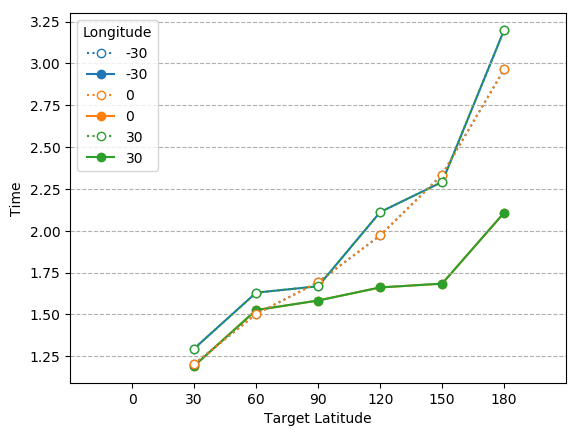

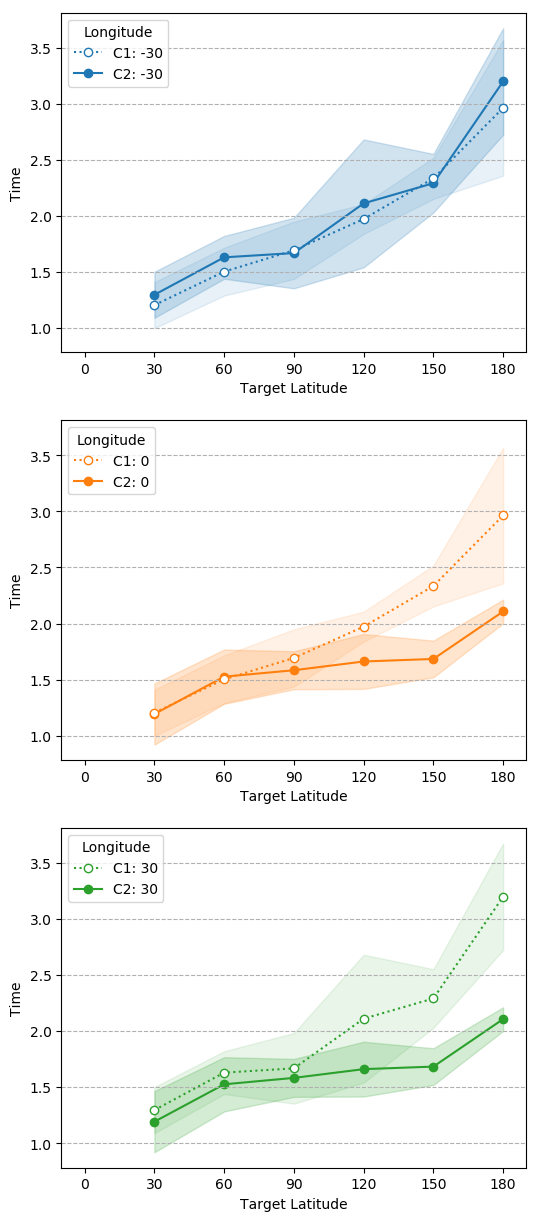

(3, 7)
#####
ratio [[1.         1.07670895 1.08493253 0.98549212 1.07079079 0.98146932
  1.07953881]
 [1.         0.99065893 1.01561382 0.93522407 0.84243779 0.72118322
  0.71109231]
 [1.         0.92008052 0.93610782 0.94899193 0.78674359 0.73479956
  0.65870009]]
log [[ 0.          0.10662832  0.11760532 -0.02108376  0.09867664 -0.02698492
   0.11041511]
 [ 0.         -0.01353965  0.02235193 -0.09661604 -0.24735794 -0.47156226
  -0.49189125]
 [ 0.         -0.12016798 -0.09525339 -0.07553228 -0.34603457 -0.44457734
  -0.60230636]]
#####
RATIO!!
remove one
remove one
remove one


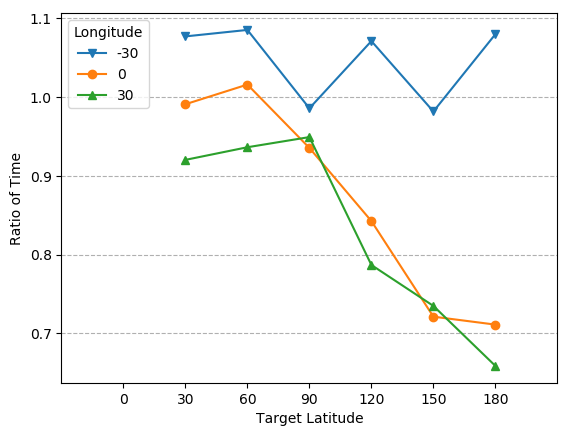

LOG!!
remove zero
remove zero
remove zero


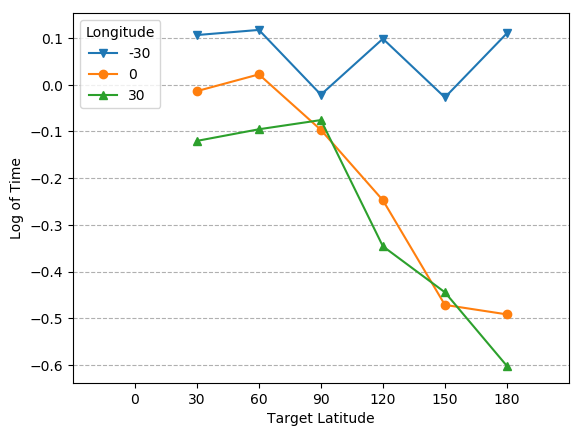

(6, 7, 3)
3
data to cal is (3, 7, 6)
(6, 7, 3)
3
data to cal is (3, 7, 6)
(6, 7, 3)
3
data to cal is (3, 7, 6)
(6, 7, 3)
3
data to cal is (3, 7, 6)


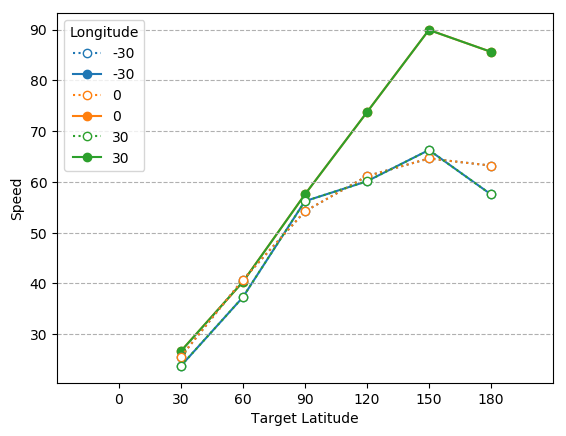

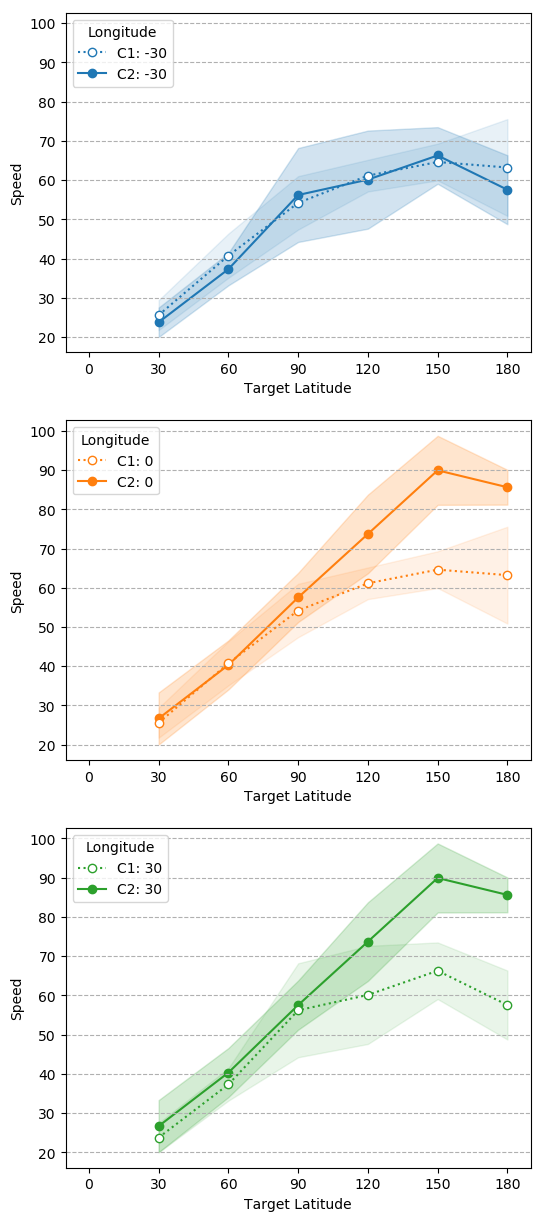

(3, 7)
#####
ratio [[1.         0.928465   0.91565391 1.03697182 0.98342266 1.02583717
  0.91033338]
 [1.         1.04251153 0.98977409 1.0614187  1.20575124 1.39197256
  1.35466605]
 [1.         1.12283341 1.08094782 1.02357526 1.22607633 1.35691375
  1.48809884]]
log [[ 0.         -0.10708057 -0.1271257   0.05237669 -0.0241165   0.03680175
  -0.13553311]
 [ 0.          0.06006334 -0.01482881  0.08599388  0.2699323   0.47713077
   0.43793725]
 [ 0.          0.1671439   0.11229688  0.03361719  0.29404879  0.44032902
   0.57347036]]
#####
RATIO!!
remove one
remove one
remove one


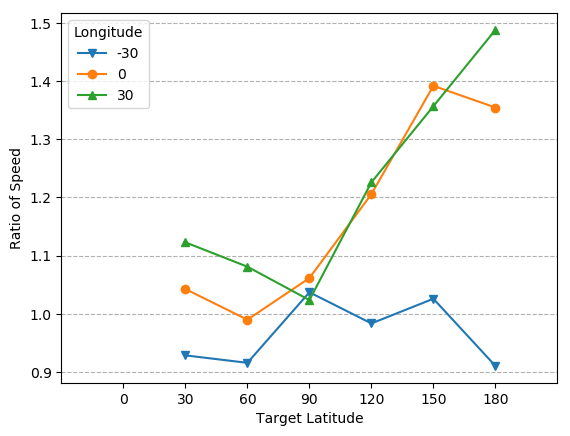

LOG!!
remove zero
remove zero
remove zero


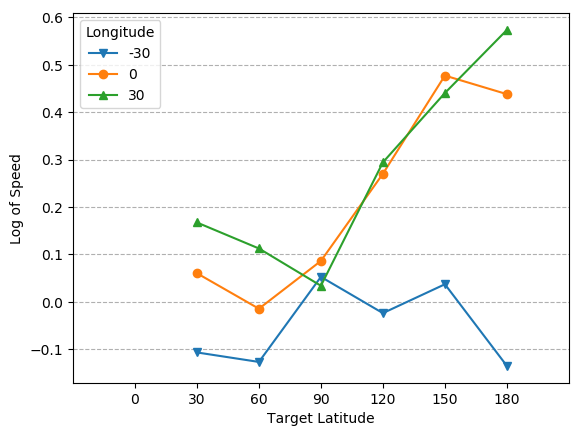

In [154]:
#print(Speed(time_mean_334, '345'))
#print(Speed(time_mean_455, '345'))
#print(np.array(m_mean(Speed(time_10x334.T, '345').value)))

#print(np.array(time_std_455))
#print(np.array(m_std(time_10x455.T)))



plot_line_dual_any_plus('Time', m_mean(time_10x334.T), m_mean(time_10x455.T),
                        m_std(time_10x334.T), m_std(time_10x455.T))
plot_line_dual_any_plus('Speed', m_mean(Speed(time_10x334, '345').value.T), 
                        m_mean(Speed(time_10x455, '345').value.T),
                        m_std(Speed(time_10x334, '345').value.T), 
                        m_std(Speed(time_10x455, '345').value.T))

[[1.45975071 1.7809     1.98508214 2.13251893 2.61326714 3.57389679
  5.44027714]
 [0.         1.01956821 1.55741786 1.70102036 2.21899643 3.17995714
  4.91231429]
 [1.45521821 1.44425714 2.24179643 2.33334643 2.65550179 3.70727179
  5.05887107]]
[[1.45975071 1.7809     1.98508214 2.13251893 2.61326714 3.57389679
  5.44027714]
 [0.         1.01956821 1.55741786 1.70102036 2.21899643 3.17995714
  4.91231429]
 [1.45521821 1.44425714 2.24179643 2.33334643 2.65550179 3.70727179
  5.05887107]]
2.623561500000001 2.084302464285713


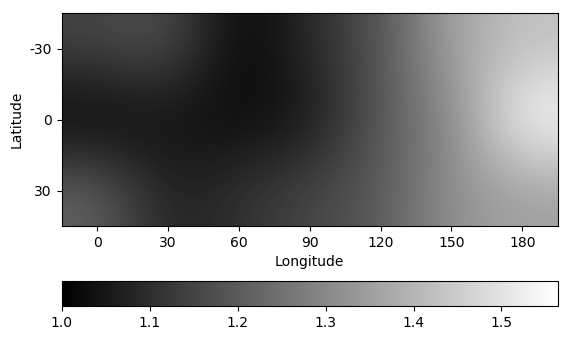

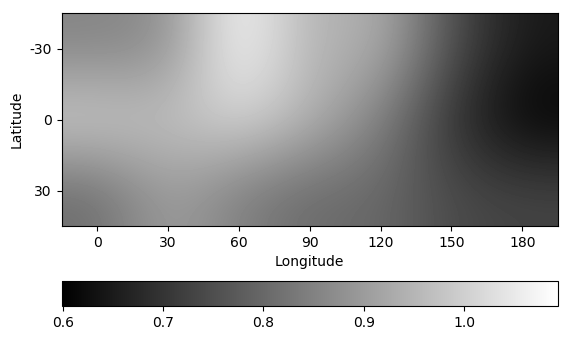

In [155]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_heatmap_3x7(input_data):

    fig, ax = plt.subplots()
    
    y = LAT_KEY_F
    x = LON_KEY_F
    z = np.array(input_data)
    im = ax.imshow(z, cmap=cm.gray, interpolation='bicubic')
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, ax=ax, orientation="horizontal")
    
    plt.xticks(range(len(x)),x)
    plt.yticks(range(len(y)),y)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    export_img('heatmap')
    plt.show()

#print(np.array(test1.time_mean_group))
print(np.array(test1.time_mean_3x7))
#print(np.delete(np.array(test1.time_mean_3x7), 7))
print(test1.median.time_3x7_mean)
print(test1.time_mean_overall, test2.time_mean_overall)


ratio_speed, log_speed= User.cal_ratio(test1.speed_mean_3x7, test2.speed_mean_3x7)
ratio_time, log_time= User.cal_ratio(test1.time_mean_3x7, test2.time_mean_3x7)
plot_heatmap_3x7(ratio_speed)
plot_heatmap_3x7(ratio_time)

(14, 3, 7)
[26.11610109 29.69889868 35.16140858 50.2060068  50.36922268 49.00916409
 44.73151595 34.13307071 36.95349985 68.18584276 68.47872597 58.4637689
 58.80454779 24.86227834 33.45510455 31.41621679 45.92882031 51.85995132
 46.59444775 33.54366768]
(20, 14)
2
[25.73781743 28.69441116 34.95089018 50.14486294 47.78257042 46.17409037
 44.66113365 33.69934567 29.04443799 67.60055583 67.59135394 57.95645538
 58.38137634 23.85069465 32.75144904 31.31410606 45.50970874 51.34405694
 46.50254688 30.35131649]
(14, 20)
(20, 14)
2
(20, 14)
2
t_all -3.2695665394007416 p_all 0.006094358304165638
=== T-statistics ===
[ -0.79601331  -5.233824    -3.74918662  -2.90501282  -4.25879665
  -3.24675607   3.69121679  -3.80404003  -3.00435245  -4.26044505
 -10.35071714  -0.13648606   0.78387127  -2.25692658]
=== P-value ===
[4.35857574e-01 4.72848627e-05 1.35849687e-03 9.07812216e-03
 4.24416657e-04 4.24454985e-03 1.55047610e-03 1.19866813e-03
 7.29110978e-03 4.22824824e-04 3.01194191e-09 8.92872861e-01

/anaconda3/envs/leoncv/lib/python3.7/site-packages/ipykernel_launcher.py:78: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


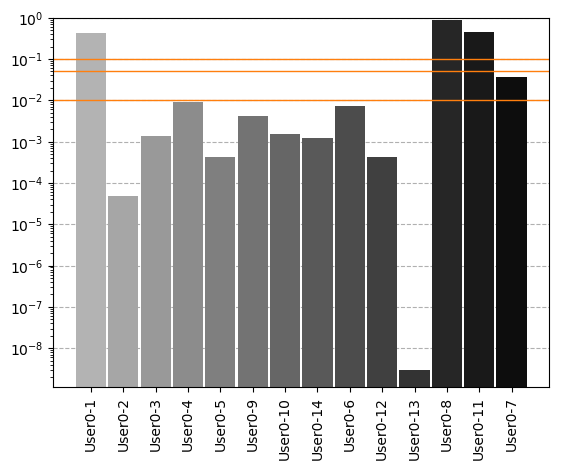

In [156]:
def cal_ttest_20(t1, t2):
    tvalue=[]
    pvalue=[]
    for user in range(len(t1)):
        tv,pv = ttest_rel(t1[user], t2[user])
        tvalue.append(tv)
        pvalue.append(pv)# *30
    
    d1 =[]
    d2 =[]
    for user in range(len(t1)):
        data_1 = [i for i in np.array(t1[user]).flat if (i!=0)]
        data_2 = [i for i in np.array(t2[user]).flat if (i!=0)]
        d1.append(np.mean(data_1))
        d2.append(np.mean(data_2))
        
    t_all,p_all = ttest_rel(d1, d2)
    print('t_all', t_all, 'p_all', p_all)
    
    print('=== T-statistics ===')
    print(np.array(tvalue))
    print('=== P-value ===')
    print(np.array(pvalue))
    
    return tvalue, pvalue



t1_speed_10x3x7=test1.speed_mean_10x3x7
t2_speed_10x3x7=test2.speed_mean_10x3x7
print(np.array(t1_speed_10x3x7).shape)
t1_speed_10=[np.delete(np.array(i).flatten(), 7) for i in t1_speed_10x3x7]
print(np.array(t1_speed_10)[0])
print(np.array(Speed(test1.mean.time_20x10).value.T)[0])
t1_ss=[ [j for j in np.array(t1_speed_10x3x7[1]).flatten() if (j!=0)] for i in t1_speed_10x3x7]
t2_speed_10=[np.delete(np.array(i).flatten(), 7) for i in t2_speed_10x3x7]
print(np.array(t1_ss).shape)
#user_t, user_p=cal_ttest_20(t1_speed_10, t2_speed_10)
user_t, user_p=cal_ttest_20(Speed(test1.mean.time_20x10).value.T, Speed(test2.mean.time_20x10).value.T)



    
fdr(user_p, 14)
plot_bar_single([user_p], 0, 1, x_title=None, y_title=None, z_title=None)

In [157]:

def cal_lat_lon(input_data):
    lat_time=[]
    lon_time=[]
     
            
    for user in range(len(input_data)):
        u_lat=[]
        u_lon=[]
        for lat in range(3):
            u_lat.append(np.sum(input_data[user][lat]))
            
        for lon in range(7):
            u_lon.append(np.sum(np.array(input_data[user]).T[lon]))
        
        lat_time.append(u_lat)
        lon_time.append(u_lon)
        
        #lon_t=[]
        #for lon in range(7):
        #    for lat in range(3):
        #        lat_time.append(np.sum(input_data[user][lat]))
        #        lon_t.append(input_data[user][lat][lon])
        #    lon_time.append(np.sum(lon_t))
        
    return lat_time, lon_time

test1_lat_time, test1_lon_time = cal_lat_lon(test1.time_mean_10x3x7)
test2_lat_time, test2_lon_time = cal_lat_lon(test2.time_mean_10x3x7)

def cal_ttest_lat(t1_lon_time,t2_lon_time):
    lat_t=[]
    lat_p=[]
    for lat in range(len(np.array(t1_lon_time).T)):
        lat_t_temp, lat_p_temp = stats.ttest_rel(np.array(t1_lon_time).T[lat], np.array(t2_lon_time).T[lat])
        lat_t.append(lat_t_temp)
        lat_p.append(lat_p_temp)
    print('===== T-Stats =====')
    print(np.array(lat_t))
    print('===== P-Value =====')
    print(np.array(lat_p))
    
    return lat_t, lat_p


cal_ttest_lat(test1_lon_time,test2_lon_time)
cal_ttest_lat(test1_lat_time,test2_lat_time)


angle_data= [[LON_KEY_F[:]] ]
print(angle_data)

print('###')

# print(np.sum(test1.time_mean_10x3x7[5]))
print(np.median(test1.round_10x4[5]))
print('### Lat / Lon Time ###')
cal_ttest_lat(np.array(test1.mean.time_7x10).T, np.array(test2.mean.time_7x10).T)
cal_ttest_lat(np.array(test1.mean.time_3x10).T, np.array(test2.mean.time_3x10).T)
cal_ttest_lat(np.array(test1.median.time_1x10).T, np.array(test2.median.time_1x10).T)
print('### Lat / Lon Speed ###')
cal_ttest_lat(np.array(Speed(test1.median.time_7x10).value).T,
              np.array(Speed(test2.median.time_7x10).value).T)
cal_ttest_lat(np.array(Speed(test1.median.time_3x10).value).T,
              np.array(Speed(test2.median.time_3x10).value).T)
cal_ttest_lat(np.array(Speed(test1.median.time_1x10).value).T,
              np.array(Speed(test2.median.time_1x10).value).T)

===== T-Stats =====
[2.01717569 1.00340954 0.17508641 1.310556   1.67063551 3.80276848
 4.67376311]
===== P-Value =====
[6.48134499e-02 3.33975443e-01 8.63709305e-01 2.12689697e-01
 1.18679540e-01 2.19575792e-03 4.35380765e-04]
===== T-Stats =====
[3.07799266 2.93668688 3.47245045]
===== P-Value =====
[0.00881225 0.01156388 0.00412644]
[[(0, 30, 60, 90, 120, 150, 180)]]
###
48.62741999999997
### Lat / Lon Time ###
===== T-Stats =====
[2.01717569 1.00340954 0.17508641 1.310556   1.67063551 3.80276848
 4.67376311]
===== P-Value =====
[6.48134499e-02 3.33975443e-01 8.63709305e-01 2.12689697e-01
 1.18679540e-01 2.19575792e-03 4.35380765e-04]
===== T-Stats =====
[3.07799266 2.93668688 3.47245045]
===== P-Value =====
[0.00881225 0.01156388 0.00412644]
===== T-Stats =====
[3.26194757]
===== P-Value =====
[0.00618438]
### Lat / Lon Speed ###
(7, 14)
2
(7, 14)
2
===== T-Stats =====
[-2.20993754 -1.40822516 -0.86945262 -1.72525632 -2.13342967 -4.05057945
 -4.12826845]
===== P-Value =====
[0.0456

([-3.5175778076712434], [0.003784343545397469])

===== T-Stats =====
[        nan -0.97553741 -2.39633584  0.13289164 -0.5519058   0.49177151
 -2.00450091]
===== P-Value =====
[       nan 0.37409715 0.06190061 0.89946174 0.60477235 0.64370807
 0.1013553 ]
t_all 3.73083041385257 p_all 0.013559351179545213
=====T-stats=====
[[        nan         nan         nan]
 [-0.97553741  0.15251871  1.06194848]
 [-2.39633584 -0.34504641  1.95784865]
 [ 0.13289164  1.08866227  0.57894536]
 [-0.5519058   3.68816758  2.55578176]
 [ 0.49177151  6.31141652  5.36026146]
 [-2.00450091  3.07767425  4.90647703]]
=====P-value=====
[[       nan        nan        nan]
 [0.37409715 0.88474149 0.33683659]
 [0.06190061 0.74410056 0.10758376]
 [0.89946174 0.32597083 0.58772712]
 [0.60477235 0.01417262 0.05090689]
 [0.64370807 0.00147034 0.00303868]
 [0.1013553  0.02754234 0.00444937]]
[0.99851694 0.73925976 0.78667772 0.82861672 0.816119   0.58411697
 1.13559828 0.81270297 0.84731192 0.91540171 0.43017292 0.87432801
 0.99110719 0.7175642 ]
#####
T-Test of Two Sa

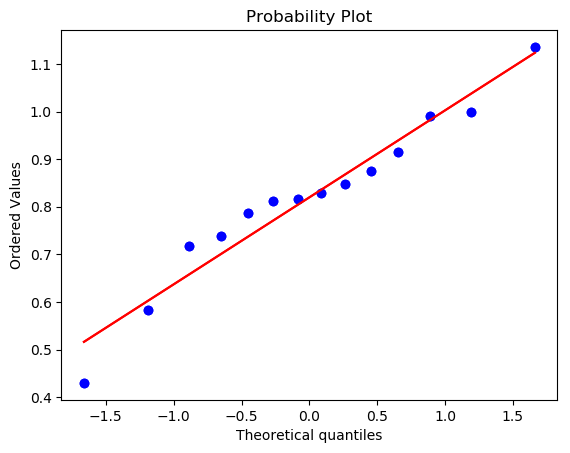

out [1.]


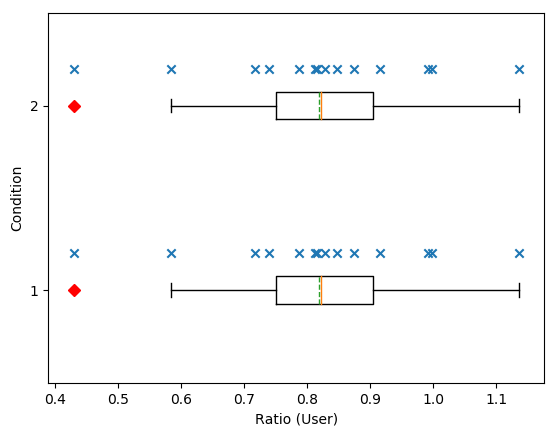

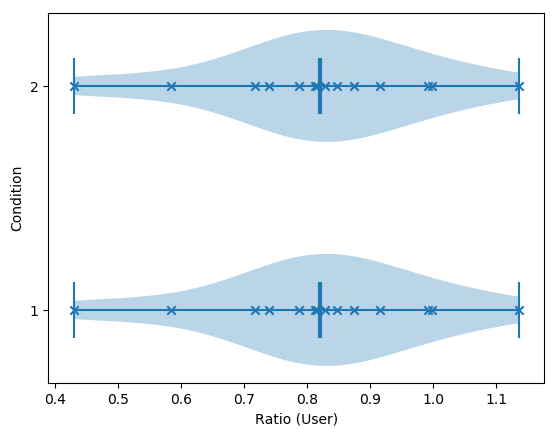

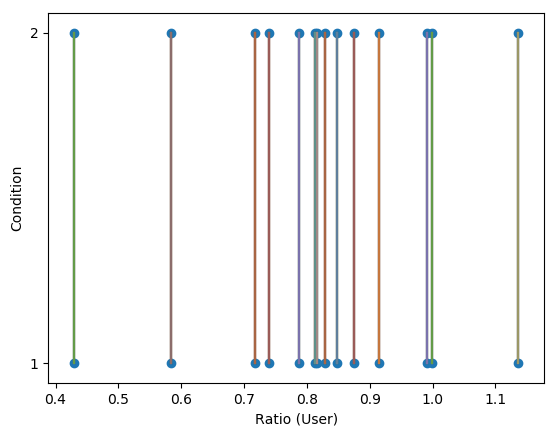

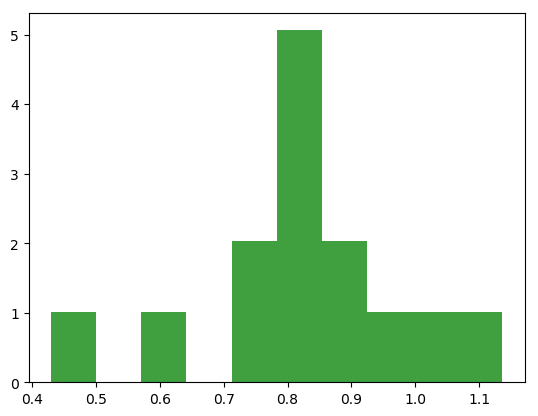

DescribeResult(nobs=14, minmax=(0.4301729203211234, 1.13559828252557), mean=0.8198210224856571, variance=0.030724440084589435, skewness=-0.45366549886019586, kurtosis=0.35283627640126225)


In [158]:
##### C3 C4 C5 #####

#print()
cal_ttest_lat(np.array(test3.median.time_7x10).T, np.array(test4.median.time_7x10).T)
cal_ttest_3x7(time_10x334, time_10x455)


new_list= list( map(lambda x,y: x/y, test2.median.time_1x10, test1.median.time_1x10) )
new_array = test2.median.time_1x10 / test1.median.time_1x10
print(new_array[0])
plot_normal_test(new_array[0], new_array[0], 'Ratio (User)')

print(stats.describe(new_array[0]))
#print(new_list)

#print (map(lambda x, y: x + y, [1, 3, 5, 7, 9], [2, 4, 6, 8, 10]))


In [159]:
from scipy import stats
pts = 1000
np.random.seed(28041990)
a = np.random.normal(0, 1, size=pts)
b = np.random.normal(2, 1, size=pts)

#x = np.concatenate((a, b))

#x = test2_round_mean
# x = 1 / np.array(test2_round_mean) almost not
#x = test2_speed_location
#x = 1 / np.array(test1_speed_location) almost not

#test1_round_mean, test2_round_mean



x = np.array(test2_condition)
x=np.array(a)+np.array(b)


#x = [i for i in np.array(test2.speed_mean_10x3x7[0]).flatten() if (i!=0)]

tar = test1.time_mean_10x3x7
count = 0
ps = []
for lat in range(3):
    for lon in range(7):
        #print(LAT_KEY[lat],LON_KEY[lon])
        x = [tar[i][lat][lon] for i in range(len(tar))]
        #print(x)
        #print(stats.normaltest(x))
        k2, p = stats.normaltest(x)
        
        ps.append(p)

        #alpha = 1e-3
        alpha = 0.05
        print("p = {:g}".format(p))
        

        if p < alpha:  # null hypothesis: x comes from a normal distribution
            print("The null hypothesis can be rejected\n NO")
        else:
            #print("The null hypothesis cannot be rejected\n YES")
            count = count + 1

print("#####{:g}/20".format(count))
print(ps)
    

tar = test2.round_10x4
#tar = average_speed_1

count = 0
ps = []
for lon in range(len(tar[0])):
    #print(LAT_KEY[lat],LON_KEY[lon])
    x = [tar[i][lon] for i in range(len(tar))]
    #print(x)
    #print(stats.normaltest(x))
    
    # condition time
    #x=[ np.sum(tar[i]) for i in range(len(tar))]
    k2, p = stats.normaltest(x)
    
    ps.append(p)

    #alpha = 1e-3
    alpha = 0.05
    print("p = {:g}".format(p))

    

    if (p < alpha):  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected\n NO")
    else:
        print("The null hypothesis cannot be rejected\n YES")
        count = count + 1
        
print("#####{:g}/4".format(count))
print(ps) 
    


p = 4.11631e-07
The null hypothesis can be rejected
 NO
p = 0.97096
p = 0.464744
p = 0.795131
p = 0.881562
p = 0.447836
p = 0.00108665
The null hypothesis can be rejected
 NO
p = 8.80282e-141
The null hypothesis can be rejected
 NO
p = 0.314176
p = 0.410645
p = 0.433821
p = 0.530437
p = 0.0070269
The null hypothesis can be rejected
 NO
p = 0.0180273
The null hypothesis can be rejected
 NO
p = 0.0706977
p = 0.000188777
The null hypothesis can be rejected
 NO
p = 0.703551
p = 0.263412
p = 0.00104983
The null hypothesis can be rejected
 NO
p = 0.0282845
The null hypothesis can be rejected
 NO
p = 0.985373
#####13/20
[4.1163077408589416e-07, 0.9709604977199879, 0.46474360833155004, 0.7951309280633739, 0.8815624535291814, 0.44783617181373214, 0.0010866482518605363, 8.802824504652152e-141, 0.3141755843425138, 0.4106451584352375, 0.4338208697152799, 0.5304374125542377, 0.007026896098869118, 0.018027296230651264, 0.07069765656131996, 0.00018877711465176627, 0.7035512635943806, 0.26341231820823

In [160]:
def anova_10x4(input_1, input_2):
    
    new_r_1 = np.array(input_1).T
    new_r_2 = np.array(input_2).T
    
    print("ANOVA of first sample")
    print(stats.f_oneway(new_r_1[0], new_r_1[1], new_r_1[2], new_r_1[3]))

    print("ANOVA of second sample")
    print(stats.f_oneway(new_r_2[0], new_r_2[1], new_r_2[2], new_r_2[3]))
    
    return



NormaltestResult(statistic=0.49986818364851626, pvalue=0.7788521141018323)
NormaltestResult(statistic=1.9703692238303603, pvalue=0.3733702919690767)
##ttest_rel(new_r_1_mean, new_r_2_mean)
Ttest_relResult(statistic=-5.522418126592068, pvalue=2.5092617718107198e-05)
new_r_mean_ratio_mean 1.1991472800499356
another way 1.20185377315136
new_r_mean_1/ratio_mean 0.8455972112319199


NameError: name 'out' is not defined

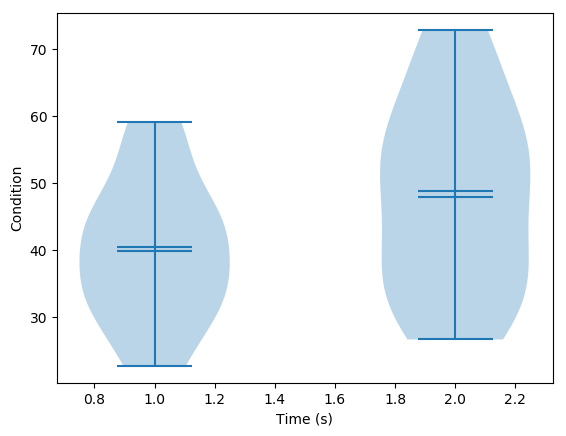

In [161]:
new_r_1 = np.array(test1.round_10x4).T
new_r_2 = np.array(test2.round_10x4).T

new_r_1_mean = np.delete(np.array(test1.speed_mean_3x7).flatten(), 7)
new_r_2_mean = np.delete(np.array(test2.speed_mean_3x7).flatten(), 7)

print(stats.normaltest(new_r_1_mean))
print(stats.normaltest(new_r_2_mean))

print("##ttest_rel(new_r_1_mean, new_r_2_mean)")
print(ttest_rel(new_r_1_mean, new_r_2_mean))


new_r_mean_ratio = []
for i in range(len(new_r_1_mean)):
    new_r_mean_ratio.append(new_r_2_mean[i] / new_r_1_mean[i])
new_r_mean_ratio_mean = np.mean(new_r_mean_ratio)

print('new_r_mean_ratio_mean', new_r_mean_ratio_mean)
print('another way', np.mean(new_r_2_mean) / np.mean(new_r_1_mean))

new_r_mean_ratio = []
for i in range(len(new_r_1_mean)):
    new_r_mean_ratio.append(new_r_1_mean[i] / new_r_2_mean[i])
new_r_mean_ratio_mean = np.mean(new_r_mean_ratio)

print('new_r_mean_1/ratio_mean', new_r_mean_ratio_mean)
    
from pylab import *
fig, ax = plt.subplots()

#r = ax.boxplot([new_r_1_mean, new_r_2_mean],  0, 'rD', 0, showmeans=True)
ax.violinplot([new_r_1_mean, new_r_2_mean],
               showmeans=True, showmedians=True, showextrema=True)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Condition')
#ax.scatter([new_r_1_mean, new_r_2_mean],
#            [[1.2 for i in new_r_1_mean], [2.2 for i in new_r_2_mean]],
 #           marker = "x")

#out = r["fliers"][0].get_data()[1]
print("out", out)

#print(new_r_1.shape)
print(new_r_1_mean)
print(new_r_2_mean)



def distance():
        
    distance=[]

    for lat in ['-30', '0', '30']:
        dis=[]
        for lon in ['0', '30', '60', '90', '120', '150', '180']:
            angle = angle_ac(int(lat), int(lon))
            dis.append(angle)
        distance.append(dis)

    return distance   # 3*3*7 array{}



def angle_ac(lat, lon):
    angle = math.degrees( math.acos( math.cos(math.radians(lat)) * math.cos(math.radians(lon)) ) )
    return angle
    
    

distance = distance()
fig2, ax2 = plt.subplots()
print(np.array(distance))
print(np.array(test1.time_mean_3x7))
ax2.scatter( np.array(distance).flatten(),
             np.array(test1.speed_mean_3x7).flatten(), marker = "+")
ax2.scatter( np.array(distance).flatten(),
             np.array(test2.speed_mean_3x7).flatten(), marker = "o")
plt.show()


In [ ]:
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)
pts =1000
a = np.random.normal(0, 1, size=pts)
b = np.random.normal(2, 1, size=pts)
x = np.concatenate((a, b))

# Load the example tips dataset
#tips = sns.load_dataset("tips")
tips = {'C1':list(np.array(test1.time_mean_3x7).flatten()),
                'C2':list(np.array(test2.time_mean_3x7).flatten())}
tips=b
#print(tips)


# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(x=tips, #hue="C1",
               split=True, inner="quart",
               #palette={0: "y", 1: "b"},
               #data = tips,
               orient = 'v')
              
#sns.despine(left=True)

from scipy import stats
pts = 1000
np.random.seed(28041990)
a = np.random.normal(0, 1, size=pts)
b = np.random.normal(2, 1, size=pts)

#x = np.concatenate((a, b))

x = b

#x = test2_round_mean
# x = 1 / np.array(test2_round_mean) almost not
#x = test2_speed_location
#x = 1 / np.array(test1_speed_location) almost not

k2, p = stats.normaltest(x)

alpha = 1e-3
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected\n NO")
else:
    print("The null hypothesis cannot be rejected\n YES")


In [ ]:
X = [-30,0,30]
Y = [0,30,60,90,120,150,180]
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
print(Z)
print(type(Z))
print(Z[0][0].shape ==())



In [ ]:
print(np.arange(-5, 5, 0.25))

In [ ]:
_x = np.arange(4)
_y = np.arange(5)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = x + y
bottom = np.zeros_like(top)
print(x)
print(y)
print(top)
print(bottom)
listx = list(x)
listx.sort()
print(listx)
print(listx[1:-1])
print(np.median([5,1,2,5]))


In [ ]:
A = np.random.rand(5, 5)

print(np.delete(A,6))
print(A)

In [ ]:

## Define 2 random distributions
#Sample Size
N = 10
#Gaussian distributed data with mean = 2 and var = 1
a = np.random.randn(N) + 2
#Gaussian distributed data with with mean = 0 and var = 1
b = np.random.randn(N)


## Calculate the Standard Deviation
#Calculate the variance to get the standard deviation

#For unbiased max likelihood estimate we have to divide the var by N-1, and therefore the parameter ddof = 1
var_a = a.var(ddof=1)
var_b = b.var(ddof=1)

#std deviation
s = np.sqrt((var_a + var_b)/2)
s



## Calculate the t-statistics
t = (a.mean() - b.mean())/(s*np.sqrt(2/N))



## Compare with the critical t-value
#Degrees of freedom
df = 2*N - 2

#p-value after comparison with the t 
p = 1 - stats.t.cdf(t,df=df)


print("t = " + str(t))
print("p = " + str(2*p))
### You can see that after comparing the t statistic with the critical t value (computed internally) we get a good p value of 0.0005 and thus we reject the null hypothesis and thus it proves that the mean of the two distributions are different and statistically significant.


## Cross Checking with the internal scipy function
t2, p2 = stats.ttest_ind(a,b)
print("t2 = " + str(t2))
print("p2 = " + str(p2))

In [ ]:
from matplotlib.patches import Polygon


# Fixing random state for reproducibility
np.random.seed(19680801)

# fake up some data
spread = np.random.rand(50) * 100
center = np.ones(25) * 50
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
data = np.concatenate((spread, center, flier_high, flier_low))

fig, axs = plt.subplots(2, 3)

# basic plot
axs[0, 0].boxplot(data)
axs[0, 0].set_title('basic plot')

# notched plot
axs[0, 1].boxplot(data, 1)
axs[0, 1].set_title('notched plot')

# change outlier point symbols
axs[0, 2].boxplot(data, 0, 'g.')
axs[0, 2].set_title('change outlier\npoint symbols')


In [ ]:
from pylab import *
spread= rand(50) * 100
center = ones(25) * 50
flier_high = rand(10) * 100 + 100
flier_low = rand(10) * -100
data =concatenate((spread, center, flier_high, flier_low), 0)
r = boxplot(data, 0, 'rD')
top_points = r["fliers"][0].get_data()[1]
#bottom_points = r["fliers"][2].get_data()[1]
plot(np.ones(len(top_points)), top_points, "+")
plt.show()
#plot(np.ones(len(bottom_points)), bottom_points, "+")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


points = np.ones(5)  # Draw 3 points for each line
text_style = dict(horizontalalignment='right', verticalalignment='center',
                  fontsize=12, fontdict={'family': 'monospace'})
marker_style = dict(color='cornflowerblue', linestyle=':', marker='o',
                    markersize=15, markerfacecoloralt='gray')


def format_axes(ax):
    ax.margins(0.2)
    ax.set_axis_off()


fig, ax = plt.subplots()

# Plot all fill styles.
for y, fill_style in enumerate(Line2D.fillStyles):
    ax.text(-0.5, y, repr(fill_style), **text_style)
    ax.plot(y * points, fillstyle=fill_style, **marker_style)
    format_axes(ax)
    ax.set_title('fill style')

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter  # useful for `logit` scale

# Fixing random state for reproducibility
np.random.seed(19680801)

# make up some data in the interval ]0, 1[
y = np.random.normal(loc=0.5, scale=0.4, size=1000)
y = y[(y > 0) & (y < 1)]
y.sort()
x = np.arange(len(y))

# plot with various axes scales
plt.figure(1)

# linear
plt.subplot(221)
plt.plot(x, y)
plt.bar(200, 0.5, 10, color= '0.5')
plt.yscale('linear')
plt.title('linear')
plt.grid(True)


# log
plt.subplot(222)
plt.plot(x, y)
plt.bar(200, 0.5, 10, color= '0.5')
plt.yscale('log')
plt.title('log')
plt.grid(True)


# symmetric log
plt.subplot(223)
plt.plot(x, y - y.mean())
plt.bar(200, 0.5, 10, color= '0.5')
plt.yscale('symlog', linthreshy=0.01)
plt.title('symlog')
plt.grid(True)

# logit
plt.subplot(224)
plt.plot(x, y)
plt.bar(200, 0.5, 10, color= '0.5')
plt.yscale('logit')
plt.title('logit')
plt.grid(True)
# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
plt.gca().yaxis.set_minor_formatter(NullFormatter())
# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter  # useful for `logit` scale

# Fixing random state for reproducibility
np.random.seed(19680801)

# make up some data in the interval ]0, 1[
y = np.random.normal(loc=0.5, scale=0.4, size=1000)
y = y[(y > 0) & (y < 1)]
y.sort()
x = np.arange(len(y))

# plot with various axes scales
plt.figure(1)

# linear
plt.subplot(221)
plt.plot(x, y)
plt.bar(200, 0.5, 10, color= '0.5')
plt.yscale('linear')
plt.title('linear')
plt.grid(True)

z = [math.log2(i) for i in y]
# log
plt.subplot(222)
plt.plot(x, z)
plt.bar(200, 0.5, 10, color= '0.5')
plt.yscale('linear')
plt.title('linear')
plt.grid(True)



In [50]:
r = [1,2,3,4,5]
print(len(r))
v = r[:4]
print(v)
print(r[:])

5
[1, 2, 3, 4]
[1, 2, 3, 4, 5]


In [ ]:
def remove_zero(input_data):
        data_new = list(input_data)[:]
        if (0 in input_data):         
            data_new.remove(0.)
        return data_new
    
remove_zero([0,1,2,3,5])
remove_zero([0,1,2,3,5])

In [75]:
kkk = [[] for x in range(5)]
jjj = np.zeros((5,1))
print(kkk)
print(list(jjj))

lll = [[None for _ in range(5)] for _ in range(6)]
print(lll)

[[], [], [], [], []]
[array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]
[[[], [], [], [], []], [[], [], [], [], []], [[], [], [], [], []], [[], [], [], [], []], [[], [], [], [], []], [[], [], [], [], []]]


In [326]:
def hi(name="yasoob"):
    return "hi " + name

print(hi())
# output: 'hi yasoob'

# 我们甚至可以将一个函数赋值给一个变量，比如
greet = hi
# 我们这里没有在使用小括号，因为我们并不是在调用hi函数
# 而是在将它放在greet变量里头。我们尝试运行下这个

print(greet())
# output: 'hi yasoob'

print(np.mean(1))

hi yasoob
hi yasoob
1.0


In [289]:
class strtest:
    def __init__(self):
        print ("init: this is only test")
    def __str__(self):
        return "str: this is only test"
t=strtest()
#print(t)

init: this is only test


<class 'int'>
